# Question 4: Miniproject
----
### Cell type classification

## 0. Setting

In [1]:
# GOOGLE COLLAB
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [ ]:
base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)

from helpers import *
from utils import remove_top_right_frame, jitter_scatterplot

In [3]:
class_color = {'EXC':'k',
               'PV':'indianred',
               'VIP':'royalblue',
               'SST':'darkorange'}
cell_class_order = ['EXC', 'PV', 'VIP', 'SST']

## 1. Data Extraction

In [6]:
# google collab
data = pd.read_csv('/content/drive/MyDrive/Data/data.csv')
data =data.drop(columns = 'Unnamed: 0')
data.head()

cell_id  Cell_Depth Cell_Layer Cell_TargetedBrainArea cell_type  \
0  AP032_1       158.0       L2/3                     C2        PV   
1  AP035_1       188.0       L2/3                     C2        PV   
2  AP035_2       196.0       L2/3                     C2        PV   
3  AP039_1       160.0       L2/3                     C2       SST   
4  AP039_2       176.0       L2/3                     C2       SST   

   firing_rate  ap_threshold  ap_duration   mean_vm    std_vm  ...  \
0     0.875000     -0.040795     0.608929 -0.064378  0.005948  ...   
1     2.100000     -0.037562     0.786111 -0.058273  0.006374  ...   
2     0.900000     -0.031695     0.849537 -0.055222  0.006061  ...   
3     0.566667     -0.040215     0.866176 -0.060517  0.004220  ...   
4     1.274725     -0.039683     0.766810 -0.064438  0.005904  ...   

   vm_amplitude_pre_FW  vm_amplitude_post_FW  ap_fr_pre_FW  ap_fr_post_FW  \
0           -55.504155            -55.399560     23.241104      27.065590   
1           -54.334653            -59.056842     24.381095       7.501875   
2           -50.060496            -53.241710     39.176461      19.588230   
3           -57.928339            -62.284089      0.000000       0.000000   
4           -49.709697            -54.663019      5.001250       1.154135   

   wp_amplitude_pre_AT  wp_amplitude_post_AT  vm_amplitude_pre_AT  \
0           193.537640            199.918717           -50.443263   
1           193.537640            199.918717           -50.443263   
2           193.537640            199.918717           -50.443263   
3           191.997949            199.756400           -52.285500   
4           191.997949            199.756400           -52.285500   

   vm_amplitude_post_AT  ap_fr_pre_AT  ap_fr_post_AT  
0            -47.847680     34.457937      78.611121  
1            -47.847680     34.457937      78.611121  
2            -47.847680     34.457937      78.611121  
3            -51.649055      8.013646      18.354518  
4            -51.649055      8.013646      18.354518  

[5 rows x 24 columns]

In [ ]:
# Load data raw
main_dir = r'../'
print('Main working directory:', main_dir)
figure_path = os.path.join(main_dir, 'Figures')
os.makedirs(figure_path, exist_ok=True)
data_path = os.path.join(main_dir, 'Data')
fname = 'data_bio482.pkl'
data_df = pd.read_pickle(os.path.join(data_path, fname))

Main working directory: ../


FileNotFoundError: [Errno 2] No such file or directory: '../Data/data_bio482.pkl'

## Cell properties

### PART0

In [ ]:
data_df.head()

Cell_APThreshold_Slope Cell_Anatomy  Cell_Counter  Cell_Depth  Cell_ID  \
0                    10.0         L2/3           1.0       229.0  SC901_1   
1                    10.0         L2/3           1.0       229.0  SC901_1   
2                    10.0         L2/3           1.0       229.0  SC901_1   
3                    10.0         L2/3           1.0       229.0  SC901_1   
4                    10.0         L2/3           1.0       229.0  SC901_1   

  Cell_Layer Cell_TargetedBrainArea Cell_Type Cell_tdTomatoExpressing  \
0       L2/3                     C2       EXC                   False   
1       L2/3                     C2       EXC                   False   
2       L2/3                     C2       EXC                   False   
3       L2/3                     C2       EXC                   False   
4       L2/3                     C2       EXC                   False   

   Mouse_DateOfBirth  ... Sweep_Counter  \
0                NaN  ...           1.0   
1                NaN  ...           2.0   
2                NaN  ...           3.0   
3                NaN  ...           4.0   
4                NaN  ...           5.0   

                             Sweep_MembranePotential  \
0  [-0.044009375, -0.044028125, -0.0439875, -0.04...   
1  [-0.046275, -0.04629375, -0.046259375, -0.0462...   
2  [-0.041896875, -0.0419125, -0.041909375, -0.04...   
3  [-0.04655625, -0.0465875, -0.046575, -0.046596...   
4  [-0.047296875, -0.047284375, -0.047265625, -0....   

  Sweep_MembranePotential_SamplingRate  \
0                              20000.0   
1                              20000.0   
2                              20000.0   
3                              20000.0   
4                              20000.0   

                           Sweep_PassiveContactTimes  \
0  [[4.567, 4.713], [7.327, 7.519], [14.481, 14.6...   
1  [[15.274999999999999, 15.375], [16.247, 16.643...   
2  [[4.347000000000001, 7.0390000000000015], [8.2...   
3                                                nan   
4  [[4.411000000000001, 4.4809999999999945], [5.2...   

                                    Sweep_QuietTimes Sweep_StartTime  \
0  [[0.002, 4.564], [4.606, 6.09], [14.634, 15.52...          2005.0   
1  [[0.002, 4.496], [5.558, 6.626], [13.406, 15.2...          2005.0   
2      [[0.002, 2.128], [6.252, 7.01], [7.15, 20.0]]          2005.0   
3  [[0.002, 2.764], [12.03, 14.464], [14.814, 15....          2005.0   
4  [[0.002, 3.36], [3.57, 4.424], [4.48, 5.224], ...          2005.0   

        Sweep_Type                                 Sweep_WhiskerAngle  \
0     active touch  [2.740000000000009, 2.740000000000009, 2.74000...   
1     active touch  [2.680000000000007, 2.680000000000007, 2.68000...   
2  passive contact  [1.4958937492820894, 1.5019819900587095, 1.509...   
3     active touch  [2.467493802679826, 2.459711310964792, 2.46562...   
4     active touch  [2.4399999999999977, 2.4399999999999977, 2.440...   

  Sweep_WhiskerAngle_SamplingRate  \
0                           100.0   
1                           100.0   
2                           100.0   
3                           100.0   
4                           100.0   

                                 Sweep_WhiskingTimes  
0                  [[6.118, 6.326], [7.942, 13.856]]  
1  [[4.7, 5.196], [6.696, 11.15], [12.032, 13.006...  
2                    [[2.15, 3.652], [4.362, 5.848]]  
3  [[2.766, 12.026], [15.626, 18.406], [18.814, 1...  
4  [[5.228, 5.624], [7.462, 8.022], [11.002, 15.2...  

[5 rows x 24 columns]

In [ ]:
# Cell ID
# We do have several data for the same cell but we don't need to distinguish them
data_df['Cell_ID']

0      SC901_1
1      SC901_1
2      SC901_1
3      SC901_1
4      SC901_1
        ...   
826    AP068_1
827    AP068_1
828    AP068_1
829    AP068_1
830    AP068_1
Name: Cell_ID, Length: 831, dtype: object

In [ ]:
# Cell_Counter WTF??
data_df['Cell_Counter']

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
826    1.0
827    1.0
828    1.0
829    1.0
830    1.0
Name: Cell_Counter, Length: 831, dtype: float64

In [ ]:
# Cell_tdTomatoExpressing WTF??
data_df['Cell_tdTomatoExpressing'].value_counts()

Cell_tdTomatoExpressing
True     548
False    283
Name: count, dtype: int64

In [ ]:
# Mouse Genotype WTF??
data_df['Mouse_Genotype'].value_counts()

Mouse_Genotype
Sst-Cre                              279
C57Bl6j                              199
PV-Cre                               184
VIP_IRES_Cre                          61
Scnn1a-Cre                            52
VIP-Cre                               35
B6(Cg)-Etv1<tm1.1(cre/ERT2)Zjh>/J     21
Name: count, dtype: int64

In [ ]:
# keep :
# Properties
part0 = data_df[['Cell_ID','Cell_Depth','Cell_Layer', 'Cell_TargetedBrainArea', 'Cell_Type']]

In [ ]:
# is cell anatomy the same as cell layer ? # TODO

In [ ]:
# remove the nan in cell depth
mask = np.isnan(part0.Cell_Depth)
mask = [not m for m in mask]
part0 = part0[mask]

# remove the pb in cell targetedBrain area
part0 = part0[part0.Cell_TargetedBrainArea != 'C2?']

for col in ['Cell_Depth','Cell_Layer','Cell_TargetedBrainArea', 'Cell_Type'] :
    print(part0[col].unique())

print(len(part0))

[229. 350. 550. 244. 250. 212. 140. 650. 335. 225. 198. 516. 500. 200.
 150. 190. 300. 160. 320. 170. 330. 348. 305. 396. 223. 197. 360. 340.
 560. 665. 551. 571. 586. 601. 496. 523. 432. 440. 266. 381. 156. 256.
 354. 215. 213. 357. 314. 219. 288. 439. 410. 470. 403. 341. 582. 531.
 557. 533. 607. 630. 337. 327. 437. 333. 220. 616. 568. 451. 450. 452.
 480. 445. 490. 474. 399. 292. 263. 135. 124. 120. 141. 164. 231. 387.
 427. 429. 491. 467. 529. 462. 364. 538. 547. 497. 476. 528. 507. 521.
 514. 457. 424. 477. 473. 456. 461. 147. 154. 102. 123. 235. 227.  98.
 146. 125. 155. 207. 143. 100. 126. 149. 152.  97. 245. 184. 172. 174.
 240. 338. 368. 400. 234. 374. 443. 423. 463. 375. 222. 211. 233. 436.
 448. 425. 525. 469. 460. 430. 415. 444. 449. 269. 185. 264. 435. 570.
 169. 167. 199. 434. 465. 390. 455. 481. 421. 204. 180. 351. 391. 380.
 122. 175. 110. 113. 128. 130. 153. 157. 145. 158. 188. 196. 192. 232.
 205. 216. 176. 210. 178. 208. 194.]
['L2/3' 'L5' 'L4']
['C2' 'S1']
['EXC' 'P

In [ ]:
for col in part0.columns[1:] :
    print(col, np.unique(part0[col].isna()))

Cell_Depth [False]
Cell_Layer [False]
Cell_TargetedBrainArea [False]
Cell_Type [False]


In [ ]:
part0.rename(columns={'Cell_ID':'cell_id'}, inplace=True)
part0.rename(columns={'Cell_Type':'cell_type'}, inplace=True)

In [ ]:
# Remove the duplicat
part0 = part0.drop_duplicates()
part0 = part0.reset_index()

In [ ]:
len(part0)

237

### part1

In [ ]:
sweep_type = 'free whisking'
time_window = 2    # time window to analyze Vm (s)
freq_band_lim = [1, 10, 30, 90] # low- and high-frequency band limits (Hz)

data_df_subset = data_df[data_df['Sweep_Type']==sweep_type]
all_cells = np.unique(data_df_subset.Cell_ID)

verbose=False #set to 0 to hide individual AP plots

# Initialize a dictionary to store data for all cell
result_dict = {'cell_id': all_cells,
          'cell_type':[], # required for cell-type identification
          # Data we'll collect for Part 1a
          'firing_rate': [],
          'ap_threshold': [],
          'ap_duration': [],
          # Data we'll collect for Part 1b
          'mean_vm':[],
          'std_vm':[],
          'fft_low':[],
          'fft_high':[]
        }

result_fft_cell_type = {'EXC':[],'SST':[], 'VIP':[],'PV':[]}

exc_cell_counter = 0

# Iterate over each cell identities to collect desired data
cell_list = sorted(np.unique(data_df_subset.Cell_ID), reverse=True) #NOTE: DO NOT START WITH AC32 bc. no AP and undefined ap_params content
for idx, cell in enumerate(cell_list):
    if idx%100==0:
        print('Cell {}/{}'.format(idx, np.unique(data_df_subset.Cell_ID).shape[0]))

    # Get mouse name and cell number from cell identifier
    mouse = cell.split('_')[0]
    cell_count = float(cell.split('_')[1])

    # Get data subset for that cell
    cell_df = data_df_subset[data_df_subset.Cell_ID==cell]

    # Get cell type
    cell_type = cell_df.Cell_Type.values[0]
    result_dict['cell_type'] += [cell_type]

    # Get sweeps/trials recorded for that cell, that we are going to iterate over
    trial_list = cell_df.Sweep_Counter.values

    # Init. cell recording specific quantities: a unique duration, yielding a unique number of APs
    tot_rec_duration = 0
    tot_number_ap = 0

    # Initialize empty lists to get data for each trial/sweep
    # Part 1a
    tot_ap_thresh = []
    tot_ap_duration = []
    # Part 1b
    tot_mean_vm = []
    tot_std_vm = []
    tot_fft = []

    # For that cell, iterate over trials
    for trial in trial_list:
        #if idx % 100 == 0: # print every 100 iteration
            #print('Cell {},  trial {}'.format(cell, int(trial)))
        if cell_type == 'EXC':
            exc_cell_counter += 1

        # Get current trial data
        cell_trial_df = cell_df[cell_df.Sweep_Counter==trial]

        # Get the sampling rate and membrane potential (and derivative) from that sweep
        sr_vm = cell_trial_df['Sweep_MembranePotential_SamplingRate'].values[0] #[0] to get the content of the array
        membrane_potential = cell_trial_df['Sweep_MembranePotential'].values[0]
        ap_vm_deriv_thresh = cell_trial_df['Cell_APThreshold_Slope'].values[0]

        # Get and update recording duration for that cell by adding trial duration
        trial_rec_duration = len(membrane_potential)/sr_vm
        tot_rec_duration += trial_rec_duration

        # Detection of action potentials for that trial, and update total number of APs for that cell
        #ap_params = None
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh)
        tot_number_ap += ap_params.shape[0]

        # Check if this trial contains any AP...
        ap_duration = []
        if (ap_params.any()):
            ap_thresh_times = ap_params[:,0]
            ap_thresh_vm = ap_params[:,1]
            ap_peak_times = ap_params[:,2]
            ap_peak_vm = ap_params[:,3]
            ap_duration = ap_params[:,5] #check for no-APs (cells with no spikes in ALL trials:EXC5,16 FR=0, AP_dur=np.nan)

            #... if so, cut-out individual APs to keep subthreshold Vm only
            vm_sub = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)


        # Else if no AP, subthreshold Vm is just Vm
        else:

            vm_sub = membrane_potential.copy()

        # Once Vm_sub is obtained:
        # Compute subthreshold Vm mean and standard deviation
        mean_vm, std_vm = Function_SubThrsVm(vm_sub, sr_vm, trial_rec_duration)

        # Compute trial FFT
        fft = Function_Compute_FFTs(vm_sub, sr_vm, time_window)

        #Update current variables from the current trial
        # Part 1a
        tot_ap_thresh += [np.concatenate([ap_thresh_vm])]
        tot_ap_duration += [ap_duration]
        # Part 1b
        tot_mean_vm += [mean_vm]
        tot_std_vm += [std_vm]
        tot_fft +=  [fft]

        # Optional plotting: show AP and AP peak times
        ap_peak_index=np.round(ap_peak_times * sr_vm)
        if verbose:
            fig, ax = plt.subplots(1,1, figsize=(10,2), dpi=300)
            remove_top_right_frame(ax)
            ax.set_title('Cell {},  trial {}'.format(cell, int(trial)))
            ax.plot(membrane_potential, lw=0.5,  zorder=0)
            ax.scatter(ap_peak_index, ap_peak_vm, lw=0.5, marker='+', color='r')
            ax.set_xlabel('Time (samples)')
            ax.set_ylabel('Membrane \n potential (V)')
            plt.show()

    # Once iterated over all trials for that cell, append cell data lists to the result dictionary

    # Part 1a
    result_dict['firing_rate'] += [tot_number_ap / tot_rec_duration] # <- just the firing rate formula
    result_dict['ap_threshold'] += [np.nanmean(np.concatenate(tot_ap_thresh))] #<-concatenate trials, get trial-average
    result_dict['ap_duration'] += [np.nanmean(np.concatenate(tot_ap_duration))]


    # Part 1b
    result_dict['mean_vm'] += [np.nanmean(np.concatenate(tot_mean_vm))]
    result_dict['std_vm'] += [np.nanmean(np.concatenate(tot_std_vm))]

    # Compute mean FFT over trials
    tot_fft = np.nanmean(np.concatenate(tot_fft, axis=1), 1)
    #Store mean cell FFT
    result_fft_cell_type[cell_type] += [tot_fft]

    # We need to find which point (sample) in the FFT correspond to which frequency
    pt1 = int(freq_band_lim[0] * fft.shape[0] / (sr_vm/2) ) + 1 #1Hz into FFT point
    pt2 = int(freq_band_lim[1] * fft.shape[0] / (sr_vm/2) ) + 1 #int: slicing requires integers
    result_dict['fft_low'] += [tot_fft[pt1:pt2].mean()]

    pt3 = int(freq_band_lim[2] * fft.shape[0] / (sr_vm/2) ) + 1
    pt4 = int(freq_band_lim[3] * fft.shape[0] / (sr_vm/2) ) + 1
    result_dict['fft_high'] += [tot_fft[pt3:pt4].mean()]

## Convert each dictionary lists as numpy arrays (convenient to make dataframes)
result_dict = {key: np.array(result_dict[key]) for key in result_dict.keys()}

print('Done!')

Cell 0/232
Cell 100/232


/mnt/c/Users/ricar/OneDrive/cours/epfl/sv/MA3/neuroscience_cellular and circuit mecanism/BIO482_MiniProject_2023_Python/BIO482-miniproject/scripts/helpers.py:18: RuntimeWarning: invalid value encountered in divide
  AP_Thrs_Onset = np.diff(np.divide(Vm_Deriv - Vm_Deriv_Thrs, np.abs(Vm_Deriv - Vm_Deriv_Thrs)))
/tmp/ipykernel_127353/1589681479.py:136: RuntimeWarning: Mean of empty slice
  result_dict['ap_duration'] += [np.nanmean(np.concatenate(tot_ap_duration))]


Cell 200/232


/mnt/c/Users/ricar/OneDrive/cours/epfl/sv/MA3/neuroscience_cellular and circuit mecanism/BIO482_MiniProject_2023_Python/BIO482-miniproject/scripts/helpers.py:52: RuntimeWarning: invalid value encountered in divide
  sAP_OnOff = np.diff(np.divide(sAP_Seg, np.abs(sAP_Seg)))  # compute the binary signal


Done!


In [ ]:
part1 = pd.DataFrame(result_dict)
part1.head()

cell_id cell_type  firing_rate  ap_threshold  ap_duration   mean_vm  \
0  AP032_1       EXC     0.875000     -0.040795     0.608929 -0.064378   
1  AP032_2       EXC     1.857143     -0.040812     0.993269 -0.056189   
2  AP035_1       EXC     2.100000     -0.037562     0.786111 -0.058273   
3  AP035_2       EXC     0.900000     -0.031695     0.849537 -0.055222   
4  AP039_1       EXC     0.566667     -0.040215     0.866176 -0.060517   

     std_vm   fft_low  fft_high  
0  0.005948  0.000763  0.000070  
1  0.005208  0.000635  0.000090  
2  0.006374  0.000775  0.000053  
3  0.006061  0.000837  0.000069  
4  0.004220  0.000513  0.000054

In [ ]:
# remove the cell type
part1 = part1.drop(columns = 'cell_type')

### part2

In [ ]:
sweep_type = 'free whisking'

pre_window = 0.5 # time before whisking onset (s)
post_window = 0.5 # time after whisking onset (s)
min_event_dur = 0.2 # minimal duration of whisking episode to be considered
min_iti = 0.5 # minimal intertrial interval (ITI) between 2 consecutive whisking episode (s)
min_number_trials = 2 # minimal number of trial
bin_size = 0.05 # bin size for psth (s)
epoch_bounds = {'pre':[-0.5, -0.3],
                  'post':[0,0.2]}  # time boundaries to compute changes in whisker protraction (WP), or Vmverbose=0 #set to 0 to hide individual AP plots

# Initialize a dictionary to store data for all cell
result_dict = {'cell_id': all_cells,
          'cell_type':[],
          # This is a template, an example with whisker protraction
          'numb_events': [],
          'wp_avg': [],
          'wp_amplitude_pre': [],
          'wp_amplitude_post': [],
          # Sub. Vm
          'vm_avg': [],
          'vm_amplitude_pre': [],
          'vm_amplitude_post': [],
          # Firing rates
          'ap_avg':[],
          'ap_psth':[],
          'ap_fr_pre':[],
          'ap_fr_post':[]
        }

# Iterate over each cell identities to collect desired data
for idx, cell in enumerate(np.unique(data_df_subset.Cell_ID)):
    if idx%100==0:
        print('Cell {}/{}'.format(idx, np.unique(data_df_subset.Cell_ID).shape[0]))

    # Get mouse name and cell number from cell identifier
    mouse = cell.split('_')[0]
    cell_count = float(cell.split('_')[1])

    # Get data subset for that cell
    cell_df = data_df_subset[data_df_subset.Cell_ID==cell]

    # Get cell type
    cell_type = cell_df.Cell_Type.values[0]
    result_dict['cell_type'] += [cell_type]

    # Get sweeps/trials recorded for that cell, that we are going to iterate over
    trial_list = cell_df.Sweep_Counter.values

    # Init. cell recording specific quantities: a unique duration, yielding a unique number of APs
    tot_rec_duration=0
    tot_number_ap=0

    # Initialize empty lists to get data for each trial/sweep
    tot_ap_thresh = []
    tot_ap_duration= []

    # Template
    tot_wp_events = []

    # Vm and AP FR
    tot_vm_events = []
    tot_ap_events = []

    ## For that cell, iterate over trials
    for trial in trial_list:

        # Get current trial data
        cell_trial_df = cell_df[cell_df.Sweep_Counter==trial]

        # Get event times for that trial
        event_times = cell_trial_df['Sweep_WhiskingTimes'].values[0]

        if event_times is None: # skip when there are no events
            continue

        # Get the sampling rate and membrane potential (and derivative) from that sweep
        sr_vm = cell_trial_df['Sweep_MembranePotential_SamplingRate'].values[0] #[0] to get the content of the array
        membrane_potential = cell_trial_df['Sweep_MembranePotential'].values[0]
        ap_vm_deriv_thresh = cell_trial_df['Cell_APThreshold_Slope'].values[0]

        # Template: extract whisker angle and sampling rate of whisker video data
        whisker_angle = cell_trial_df['Sweep_WhiskerAngle'].values[0]
        sr_wp = cell_trial_df['Sweep_WhiskerAngle_SamplingRate'].values[0]

         # Get and update recording duration for that cell by adding trial duration
        trial_rec_duration = len(membrane_potential)/sr_vm
        tot_rec_duration += trial_rec_duration

        # Detection of action potentials for that trial, and update total number of APs for that cell
        #ap_params = None
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh)
        tot_number_ap += ap_params.shape[0]


        # Check if this trial contains any AP...
        ap_duration = []
        if (ap_params.any()):
            ap_thresh_times = ap_params[:,0]
            ap_thresh_vm = ap_params[:,1]
            ap_peak_times = ap_params[:,2]
            ap_peak_vm = ap_params[:,3]
            ap_duration = ap_params[:,5] #check for no-APs (cells with no spikes in ALL trials:EXC5,16 FR=0, AP_dur=np.nan)

             #... if so, cut-out individual APs to keep subthreshold Vm only
            vm_sub = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)

            #For APs, make an analog binary vector of same dimensions as Vm_Sub
            vec_length = len(vm_sub)
            ap_vect = Function_Times2Vect(ap_peak_times, sr_vm, vec_length)

        # Else if no AP, subthreshold Vm is just Vm
        else:
            vm_sub = membrane_potential.copy()
            ap_vect = np.zeros_like(vm_sub) #empty vector of size Vm_Sub

        # Once trial event times and data is collected, use this function to extract data aligned to event onset
        # -> check function (Function_Event_Triggered_Signal) parameters and code!
        # -> input data can be whatever, given a certain dimensions
        # -> events can be whatever
        # -> adjust sampling rate for data type (e.g. video, Vm)!

        wp_event = Function_Event_Triggered_Signal(whisker_angle, sr_wp,
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)
        vm_event = Function_Event_Triggered_Signal(vm_sub, sr_vm,
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)
        ap_event = Function_Event_Triggered_Signal(np.squeeze(ap_vect), sr_vm,
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)


        # Missing data in original .mat file is encoded as -1, so this skips entires with missing data
        if type(wp_event) == int:
            continue
        if type(vm_event) == int:
            continue
        if type(ap_event) == int:
            continue

        # Append each event-triggered vector and stack to an array
        tot_wp_events += [wp_event]
        tot_wp_array = np.hstack(tot_wp_events)

        tot_vm_events+= [vm_event]
        tot_vm_array=np.hstack(tot_vm_events)

        tot_ap_events+= [ap_event]
        tot_ap_array=np.hstack(tot_ap_events)


    # Compute means only if a certain number of trials is present
    n_events = tot_wp_array.shape[1]
    if (n_events >= min_number_trials):
        result_dict['numb_events'] += [n_events]

        # Calculate trial-averaged signals
        #Template: WP
        wp_avg = np.mean(tot_wp_array, 1)
        result_dict['wp_avg'] += [wp_avg] #add for that cell

        vm_avg = np.mean(tot_vm_array, 1)
        result_dict['vm_avg'] += [vm_avg]

        ap_avg = np.mean(tot_ap_array, 1)
        result_dict['ap_avg'] += [ap_avg]

        ap_psth=Function_PSTH(ap_avg, sr_vm, pre_window, post_window, bin_size)
        result_dict['ap_psth'] += [ap_psth[:,1]]


        #for epoch in range(wp_bounds.shape[0]):
        for epoch in epoch_bounds.keys():

            # Template: whisker protraction
            # Get bound of that epoch (pre/post)
            bound_1=int(np.round((epoch_bounds[epoch][0]+pre_window)*sr_wp))
            bound_2=int(np.round((epoch_bounds[epoch][1]+pre_window)*sr_wp-1))

            #Get mean in pre/post epoch
            if epoch=='pre':
                result_dict['wp_amplitude_pre'] += [wp_avg[bound_1:bound_2].mean(0)]
            else:
                result_dict['wp_amplitude_post'] += [wp_avg[bound_1:bound_2].mean(0)]

            # Vm, and AP firing rate
            bound_1=int(np.round((epoch_bounds[epoch][0]+pre_window)*sr_vm)) #sr_vm !
            bound_2=int(np.round((epoch_bounds[epoch][1]+pre_window)*sr_vm-1))

            if epoch=='pre':
                result_dict['vm_amplitude_pre'] += [vm_avg[bound_1:bound_2].mean(0) * 1000] #in mV!
                result_dict['ap_fr_pre'] += [ap_avg[bound_1:bound_2].mean(0) * sr_vm]       #in Hz!
            else:
                result_dict['vm_amplitude_post'] += [vm_avg[bound_1:bound_2].mean(0) * 1000] #in Hz!
                result_dict['ap_fr_post'] += [ap_avg[bound_1:bound_2].mean(0) * sr_vm]


    #If there are less trials than necessary, set to NaNs (exclude data)
    else:
        result_dict['numb_events'] += [n_events]

        #Template: WP
        wp_avg=np.nan*np.empty_like(wp_avg)
        result_dict['wp_avg'] += [wp_avg]
        result_dict['wp_amplitude_pre'] += [np.nan]
        result_dict['wp_amplitude_post'] += [np.nan]

        # VM
        vm_avg=np.nan*np.empty_like(vm_avg)
        result_dict['vm_avg'] += [vm_avg]
        result_dict['vm_amplitude_pre'] += [np.nan]
        result_dict['vm_amplitude_post'] += [np.nan]

        #AP firing rate
        ap_avg=np.nan*np.empty_like(ap_avg)
        result_dict['ap_avg'] += [ap_avg]
        ap_psth=Function_PSTH(ap_avg, sr_vm, pre_window, post_window, bin_size)
        result_dict['ap_psth'] += [ap_psth[:,1]]

        result_dict['ap_fr_pre'] += [np.nan]
        result_dict['ap_fr_post'] += [np.nan]


# Convert each dictionary lists as numpy arrays
result_dict = {key: np.array(result_dict[key]) for key in result_dict.keys()}

#Init. dataframe size
result_df = pd.DataFrame(index=range(np.unique(data_df_subset.Cell_ID).shape[0]),
             columns=result_dict.keys())

for key in result_dict.keys():
    result_df[key] = result_dict[key] #this works for scalars

# For array-based data, one must give a list to assign to dataframe column
# Template: WP
result_df['wp_avg'] = list(result_dict['wp_avg'])

result_df['vm_avg'] = list(result_dict['vm_avg'])
result_df['ap_avg'] = list(result_dict['ap_avg'])
result_df['ap_psth'] = list(result_dict['ap_psth'])

# times for the bins of the psth
psth_time=ap_psth[:,0]

print('Done!')

Cell 0/232


/mnt/c/Users/ricar/OneDrive/cours/epfl/sv/MA3/neuroscience_cellular and circuit mecanism/BIO482_MiniProject_2023_Python/BIO482-miniproject/scripts/helpers.py:52: RuntimeWarning: invalid value encountered in divide
  sAP_OnOff = np.diff(np.divide(sAP_Seg, np.abs(sAP_Seg)))  # compute the binary signal
/mnt/c/Users/ricar/OneDrive/cours/epfl/sv/MA3/neuroscience_cellular and circuit mecanism/BIO482_MiniProject_2023_Python/BIO482-miniproject/scripts/helpers.py:18: RuntimeWarning: invalid value encountered in divide
  AP_Thrs_Onset = np.diff(np.divide(Vm_Deriv - Vm_Deriv_Thrs, np.abs(Vm_Deriv - Vm_Deriv_Thrs)))


Cell 100/232
Cell 200/232
Done!


In [ ]:
# keep wp_amplitude_pre, wp_amplitude_post, vm_amplitude_pre, vm_amplitude_post, ap_fr_pre, ap_fr_post
part2 = result_df[['cell_id', 'cell_type', 'wp_amplitude_pre','wp_amplitude_post', 'vm_amplitude_pre', 'vm_amplitude_post', 'ap_fr_pre', 'ap_fr_post' ]]
part2.head()

cell_id cell_type  wp_amplitude_pre  wp_amplitude_post  vm_amplitude_pre  \
0  AP032_1        PV       -139.536777        -135.226516        -55.504155   
1  AP032_2        PV       -139.157622        -134.807553        -48.994021   
2  AP035_1        PV       -131.406960        -125.811327        -54.334653   
3  AP035_2        PV       -132.794568        -118.696745        -50.060496   
4  AP039_1       SST       -146.466663        -138.432118        -57.928339   

   vm_amplitude_post  ap_fr_pre  ap_fr_post  
0         -55.399560  23.241104   27.065590  
1         -50.584425  30.007502    8.752188  
2         -59.056842  24.381095    7.501875  
3         -53.241710  39.176461   19.588230  
4         -62.284089   0.000000    0.000000

In [ ]:
# Add to the columns the label for the exp
part2.columns += '_FW'
part2.rename(columns={'cell_id_FW':'cell_id'}, inplace=True)

/tmp/ipykernel_127353/3503326707.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part2.rename(columns={'cell_id_FW':'cell_id'}, inplace=True)


In [ ]:
part2 = part2.drop(columns = 'cell_type_FW')

### Part3

In [ ]:
sweep_type = 'active touch'

pre_window = 0.1 # time before touch onset (s)
post_window = 0.3 # time after touch onset (s)
min_event_dur = 0 # minimal duration of active touch episode to be considered
min_iti = 0.2 # minimal intertrial interval (ITI) between 2 consecutive touch episode (s)
min_number_trials = 2 # minimal number of trial
bin_size = 0.01 # bin size for psth (s)
epoch_bounds = {'pre':[-0.05, 0],
                  'post':[0,0.1]}  # time boundaries to compute changes in whisker protraction (WP), or Vm


data_df_subset = data_df[data_df['Sweep_Type']==sweep_type]
all_cells = np.unique(data_df_subset.Cell_ID)

verbose=0 #set to 0 to hide individual AP plots

# Initialize a dictionary to store data for all cell
result_dict = {'cell_id': all_cells,
          'cell_type':[],
          # This is a template, an example with whisker protraction
          'numb_events': [],
          'wp_avg': [],
          'wp_amplitude_pre': [],
          'wp_amplitude_post': [],
          # Sub. Vm
          'vm_avg': [],
          'vm_amplitude_pre': [],
          'vm_amplitude_post': [],
          # Firing rates
          'ap_avg':[],
          'ap_psth':[],
          'ap_fr_pre':[],
          'ap_fr_post':[]
        }

# Iterate over each cell identities to collect desired data
for idx, cell in enumerate(np.unique(data_df_subset.Cell_ID)):
    if idx%100==0:
        print('Cell {}/{}'.format(idx, np.unique(data_df_subset.Cell_ID).shape[0]))

    # Get mouse name and cell number from cell identifier
    mouse = cell.split('_')[0]
    cell_count = float(cell.split('_')[1])

    # Get data subset for that cell
    cell_df = data_df_subset[data_df_subset.Cell_ID==cell]

    # Get cell type
    cell_type = cell_df.Cell_Type.values[0]
    result_dict['cell_type'] += [cell_type]

    # Get sweeps/trials recorded for that cell, that we are going to iterate over
    trial_list = cell_df.Sweep_Counter.values

    # Init. cell recording specific quantities: a unique duration, yielding a unique number of APs
    tot_rec_duration=0
    tot_number_ap=0

    # Initialize empty lists to get data for each trial/sweep
    tot_ap_thresh = []
    tot_ap_duration= []

    # Template
    tot_wp_events = []

    # Vm and AP FR
    tot_vm_events = []
    tot_ap_events = []

    ## For that cell, iterate over trials
    for trial in trial_list:

        # Get current trial data
        cell_trial_df = cell_df[cell_df.Sweep_Counter==trial]

        # Get event times for that trial
        event_times = cell_trial_df['Sweep_ActiveContactTimes'].values[0]
        if np.isnan(event_times).all(): #if no active touch events, just skip
            continue

        # Get the sampling rate and membrane potential (and derivative) from that sweep
        sr_vm = cell_trial_df['Sweep_MembranePotential_SamplingRate'].values[0] #[0] to get the content of the array
        membrane_potential = cell_trial_df['Sweep_MembranePotential'].values[0]
        ap_vm_deriv_thresh = cell_trial_df['Cell_APThreshold_Slope'].values[0]

        # Template: extract whisker angle and sampling rate of whisker video data
        whisker_angle = cell_trial_df['Sweep_WhiskerAngle'].values[0]
        sr_wp = cell_trial_df['Sweep_WhiskerAngle_SamplingRate'].values[0]

         # Get and update recording duration for that cell by adding trial duration
        trial_rec_duration = len(membrane_potential)/sr_vm
        tot_rec_duration += trial_rec_duration

        # Detection of action potentials for that trial, and update total number of APs for that cell
        #ap_params = None
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh)
        tot_number_ap += ap_params.shape[0]


        # Check if this trial contains any AP...
        ap_duration = []
        if (ap_params.any()):
            ap_thresh_times = ap_params[:,0]
            ap_thresh_vm = ap_params[:,1]
            ap_peak_times = ap_params[:,2]
            ap_peak_vm = ap_params[:,3]
            ap_duration = ap_params[:,5] #check for no-APs (cells with no spikes in ALL trials:EXC5,16 FR=0, AP_dur=np.nan)

             #... if so, cut-out individual APs to keep subthreshold Vm only
            vm_sub = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)

            #For APs, make an analog binary vector of same dimensions as Vm_Sub
            vec_length = len(vm_sub)
            ap_vect = Function_Times2Vect(ap_peak_times, sr_vm, vec_length)


        # Else if no AP, subthreshold Vm is just Vm
        else:
            vm_sub = membrane_potential.copy()
            ap_vect = np.zeros_like(vm_sub) #empty vector of size Vm_Sub

        # Once trial event times and data is collected, use this function to extract data aligned to event onset
        # -> check function (Function_Event_Triggered_Signal) parameters and code!
        # -> input data can be whatever, given a certain dimensions
        # -> events can be whatever
        # -> adjust sampling rate for data type (e.g. video, Vm)!

        wp_event = Function_Event_Triggered_Signal(whisker_angle, sr_wp,
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)
        vm_event = Function_Event_Triggered_Signal(vm_sub, sr_vm,
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)
        ap_event = Function_Event_Triggered_Signal(np.squeeze(ap_vect), sr_vm,
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)



        #if type(wp_event) == int:
        #    continue
        #if type(vm_event) == int:
        #    continue
        #if type(ap_event) == int:
        #    continue

        # Append each event-triggered vector and stack to an array
        tot_wp_events += [wp_event]
        tot_wp_array = np.hstack(tot_wp_events)

        tot_vm_events+= [vm_event]
        tot_vm_array=np.hstack(tot_vm_events)

        tot_ap_events+= [ap_event]
        tot_ap_array=np.hstack(tot_ap_events)


    # Compute means only if a certain number of trials is present
    n_events = tot_wp_array.shape[1]
    if (n_events >= min_number_trials):
        result_dict['numb_events'] += [n_events]

        # Calculate trial-averaged signals
        #Template: WP
        wp_avg = np.mean(tot_wp_array, 1)
        result_dict['wp_avg'] += [wp_avg] #add for that cell

        vm_avg = np.mean(tot_vm_array, 1)
        result_dict['vm_avg'] += [vm_avg]

        ap_avg = np.mean(tot_ap_array, 1)
        result_dict['ap_avg'] += [ap_avg]

        ap_psth=Function_PSTH(ap_avg, sr_vm, pre_window, post_window, bin_size)
        result_dict['ap_psth'] += [ap_psth[:,1]]

        #for epoch in range(wp_bounds.shape[0]):
        for epoch in epoch_bounds.keys():

            # Template: whisker protraction
            # Get bound of that epoch (pre/post)
            bound_1=int(np.round((epoch_bounds[epoch][0]+pre_window)*sr_wp))
            bound_2=int(np.round((epoch_bounds[epoch][1]+pre_window)*sr_wp-1))

            #Get mean in pre/post epoch
            if epoch=='pre':
                result_dict['wp_amplitude_pre'] += [wp_avg[bound_1:bound_2].mean(0)]
            else:
                result_dict['wp_amplitude_post'] += [wp_avg[bound_1:bound_2].mean(0)]

            # Vm, and AP firing rate
            bound_1=int(np.round((epoch_bounds[epoch][0]+pre_window)*sr_vm)) #sr_vm !
            bound_2=int(np.round((epoch_bounds[epoch][1]+pre_window)*sr_vm-1))

            if epoch=='pre':
                result_dict['vm_amplitude_pre'] += [vm_avg[bound_1:bound_2].mean(0) * 1000] #in mV!
                result_dict['ap_fr_pre'] += [ap_avg[bound_1:bound_2].mean(0) * sr_vm]       #in Hz!
            else:
                result_dict['vm_amplitude_post'] += [vm_avg[bound_1:bound_2].mean(0) * 1000] #in Hz!
                result_dict['ap_fr_post'] += [ap_avg[bound_1:bound_2].mean(0) * sr_vm]


    #If there are less trials than necessary, set to NaNs (exclude data)
    else:
        result_dict['numb_events'] += [n_events]

        #Template: WP
        wp_avg=np.nan*np.empty_like(wp_avg)
        result_dict['wp_avg'] += [wp_avg]
        result_dict['wp_amplitude_pre'] += [np.nan]
        result_dict['wp_amplitude_post'] += [np.nan]

        # VM
        vm_avg=np.nan*np.empty_like(vm_avg)
        result_dict['vm_avg'] += [vm_avg]
        result_dict['vm_amplitude_pre'] += [np.nan]
        result_dict['vm_amplitude_post'] += [np.nan]

        #AP firing rate
        ap_avg=np.nan*np.empty_like(ap_avg)
        result_dict['ap_avg'] += [ap_avg]
        ap_psth=Function_PSTH(ap_avg, sr_vm, pre_window, post_window, bin_size)
        result_dict['ap_psth'] += [ap_psth[:,1]]
        result_dict['ap_fr_pre'] += [np.nan]
        result_dict['ap_fr_post'] += [np.nan]


# Convert each dictionary lists as numpy arrays
result_dict = {key: np.array(result_dict[key]) for key in result_dict.keys()}

#Init. dataframe size
result_df = pd.DataFrame(index=range(np.unique(data_df_subset.Cell_ID).shape[0]),
             columns=result_dict.keys())

for key in result_dict.keys():
    result_df[key] = result_dict[key] #this works for scalars

# For array-based data, on must give a list to assign to dataframe column
# Template: WP
result_df['wp_avg'] = list(result_dict['wp_avg'])

result_df['vm_avg'] = list(result_dict['vm_avg'])
result_df['ap_avg'] = list(result_dict['ap_avg'])
result_df['ap_psth'] = list(result_dict['ap_psth'])

# times for the bins of the psth
psth_time=ap_psth[:,0]

print('Done!')

Cell 0/134


/mnt/c/Users/ricar/OneDrive/cours/epfl/sv/MA3/neuroscience_cellular and circuit mecanism/BIO482_MiniProject_2023_Python/BIO482-miniproject/scripts/helpers.py:52: RuntimeWarning: invalid value encountered in divide
  sAP_OnOff = np.diff(np.divide(sAP_Seg, np.abs(sAP_Seg)))  # compute the binary signal


Cell 100/134


/mnt/c/Users/ricar/OneDrive/cours/epfl/sv/MA3/neuroscience_cellular and circuit mecanism/BIO482_MiniProject_2023_Python/BIO482-miniproject/scripts/helpers.py:18: RuntimeWarning: invalid value encountered in divide
  AP_Thrs_Onset = np.diff(np.divide(Vm_Deriv - Vm_Deriv_Thrs, np.abs(Vm_Deriv - Vm_Deriv_Thrs)))


Done!


In [ ]:
part3 = result_df[['cell_id', 'cell_type', 'wp_amplitude_pre','wp_amplitude_post', 'vm_amplitude_pre', 'vm_amplitude_post', 'ap_fr_pre', 'ap_fr_post' ]]
part3.head()

cell_id cell_type  wp_amplitude_pre  wp_amplitude_post  vm_amplitude_pre  \
0  JP902_1       EXC          1.313173           4.325349        -57.048425   
1  JP903_1       EXC          6.090980          11.033949        -68.167575   
2  JP905_1       EXC          7.643778          10.227399        -55.262389   
3  JP906_1       EXC         -4.364575          -0.040696        -55.650343   
4  JP907_1       EXC         -5.679912          -1.912861        -53.102919   

   vm_amplitude_post  ap_fr_pre  ap_fr_post  
0         -58.194868   0.000000    0.000000  
1         -66.258805   0.800801    0.000000  
2         -54.555092   1.540002    0.769616  
3         -48.444484   0.588824    4.708236  
4         -53.095735   0.000000    0.000000

In [ ]:
# Add a column for the exp label
part3.columns += '_AT'
part3.rename(columns={'cell_id_AT':'cell_id'}, inplace=True)

/tmp/ipykernel_127353/1554253047.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part3.rename(columns={'cell_id_AT':'cell_id'}, inplace=True)


In [ ]:
part3 = part3.drop(columns = 'cell_type_AT')

### MERGING

In [ ]:
merged = pd.merge(part0, part1,  on='cell_id', how='outer')
merged = merged.drop(columns ='index')

merged = pd.merge(merged, part2,  on='cell_id', how='outer')

merged = pd.merge(merged, part3, on='cell_id', how='outer')
merged.head()

cell_id  Cell_Depth Cell_Layer Cell_TargetedBrainArea cell_type  \
0  AP032_1       158.0       L2/3                     C2        PV   
1  AP032_2         NaN        NaN                    NaN       NaN   
2  AP035_1       188.0       L2/3                     C2        PV   
3  AP035_2       196.0       L2/3                     C2        PV   
4  AP039_1       160.0       L2/3                     C2       SST   

   firing_rate  ap_threshold  ap_duration   mean_vm    std_vm  ...  \
0     0.875000     -0.040795     0.608929 -0.064378  0.005948  ...   
1     1.857143     -0.040812     0.993269 -0.056189  0.005208  ...   
2     2.100000     -0.037562     0.786111 -0.058273  0.006374  ...   
3     0.900000     -0.031695     0.849537 -0.055222  0.006061  ...   
4     0.566667     -0.040215     0.866176 -0.060517  0.004220  ...   

   vm_amplitude_pre_FW  vm_amplitude_post_FW  ap_fr_pre_FW  ap_fr_post_FW  \
0           -55.504155            -55.399560     23.241104      27.065590   
1           -48.994021            -50.584425     30.007502       8.752188   
2           -54.334653            -59.056842     24.381095       7.501875   
3           -50.060496            -53.241710     39.176461      19.588230   
4           -57.928339            -62.284089      0.000000       0.000000   

   wp_amplitude_pre_AT  wp_amplitude_post_AT  vm_amplitude_pre_AT  \
0                  NaN                   NaN                  NaN   
1                  NaN                   NaN                  NaN   
2                  NaN                   NaN                  NaN   
3                  NaN                   NaN                  NaN   
4                  NaN                   NaN                  NaN   

   vm_amplitude_post_AT  ap_fr_pre_AT  ap_fr_post_AT  
0                   NaN           NaN            NaN  
1                   NaN           NaN            NaN  
2                   NaN           NaN            NaN  
3                   NaN           NaN            NaN  
4                   NaN           NaN            NaN  

[5 rows x 24 columns]

In [ ]:
len(merged)

240

In [ ]:
# The merge works
# check if we have nan cell id
print(merged['cell_id'].isna().unique())

# check if we have twice the same cell
for index, values in zip(merged['cell_id'].value_counts().index, merged['cell_id'].value_counts().values):
    if values !=1 :
        print(merged[merged['cell_id']== index])

[False]


In [ ]:
# Replace missing values by the mean of the cell type
col_to_check = []
for col in merged.columns :
    if len(np.unique(merged[col].isna())) == 2 :
        col_to_check.append(col)

# Fill the missing value by the mean of the same cell type
for col in  col_to_check :
    nanvalues_type = merged['cell_type'][merged.isna()[col]]
    print(col)

    for id, type_cell in zip(nanvalues_type.index, nanvalues_type.values) :
        value_mean = merged[merged['cell_type'] == type_cell][col].mean()
        merged.at[id, col] = value_mean

Cell_Depth
Cell_Layer
Cell_TargetedBrainArea
cell_type
firing_rate
ap_threshold
ap_duration
mean_vm
std_vm
fft_low
fft_high
wp_amplitude_pre_FW
wp_amplitude_post_FW
vm_amplitude_pre_FW
vm_amplitude_post_FW
ap_fr_pre_FW
ap_fr_post_FW
wp_amplitude_pre_AT
wp_amplitude_post_AT
vm_amplitude_pre_AT
vm_amplitude_post_AT
ap_fr_pre_AT
ap_fr_post_AT


In [ ]:
# only 3 values we can remove them because we cannot replace them
for col in ['Cell_Depth', 'Cell_Layer', 'Cell_TargetedBrainArea', 'cell_type'] :
    id = merged[merged[col].isna()].index
    merged = merged.drop(id)


In [ ]:
# sanity check :
for col in merged.columns[1:] :
    print(np.unique(merged[col].isna()))

[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]


In [ ]:
# path to save
path = os.path.join(f'{main_dir}Data/data.csv')
merged.to_csv(path)

## 2. Exploration

In [ ]:
import os, sys
import pandas as pd
import numpy as np
main_dir='../'
base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)
#data
data = pd.read_csv(f'{main_dir}Data/data.csv')

In [ ]:
data = data.drop(columns = 'Unnamed: 0')
data.head()

cell_id  Cell_Depth Cell_Layer Cell_TargetedBrainArea cell_type  \
0  AP032_1       158.0       L2/3                     C2        PV   
1  AP035_1       188.0       L2/3                     C2        PV   
2  AP035_2       196.0       L2/3                     C2        PV   
3  AP039_1       160.0       L2/3                     C2       SST   
4  AP039_2       176.0       L2/3                     C2       SST   

   firing_rate  ap_threshold  ap_duration   mean_vm    std_vm  ...  \
0     0.875000     -0.040795     0.608929 -0.064378  0.005948  ...   
1     2.100000     -0.037562     0.786111 -0.058273  0.006374  ...   
2     0.900000     -0.031695     0.849537 -0.055222  0.006061  ...   
3     0.566667     -0.040215     0.866176 -0.060517  0.004220  ...   
4     1.274725     -0.039683     0.766810 -0.064438  0.005904  ...   

   vm_amplitude_pre_FW  vm_amplitude_post_FW  ap_fr_pre_FW  ap_fr_post_FW  \
0           -55.504155            -55.399560     23.241104      27.065590   
1           -54.334653            -59.056842     24.381095       7.501875   
2           -50.060496            -53.241710     39.176461      19.588230   
3           -57.928339            -62.284089      0.000000       0.000000   
4           -49.709697            -54.663019      5.001250       1.154135   

   wp_amplitude_pre_AT  wp_amplitude_post_AT  vm_amplitude_pre_AT  \
0           193.537640            199.918717           -50.443263   
1           193.537640            199.918717           -50.443263   
2           193.537640            199.918717           -50.443263   
3           191.997949            199.756400           -52.285500   
4           191.997949            199.756400           -52.285500   

   vm_amplitude_post_AT  ap_fr_pre_AT  ap_fr_post_AT  
0            -47.847680     34.457937      78.611121  
1            -47.847680     34.457937      78.611121  
2            -47.847680     34.457937      78.611121  
3            -51.649055      8.013646      18.354518  
4            -51.649055      8.013646      18.354518  

[5 rows x 24 columns]

#### Corelation between features

In [ ]:
# all correlation
sns.pairplot(data, hue='cell_type', palette=class_color)

NameError: name 'class_color' is not defined

#### Correlation between the two studies AT , FW  

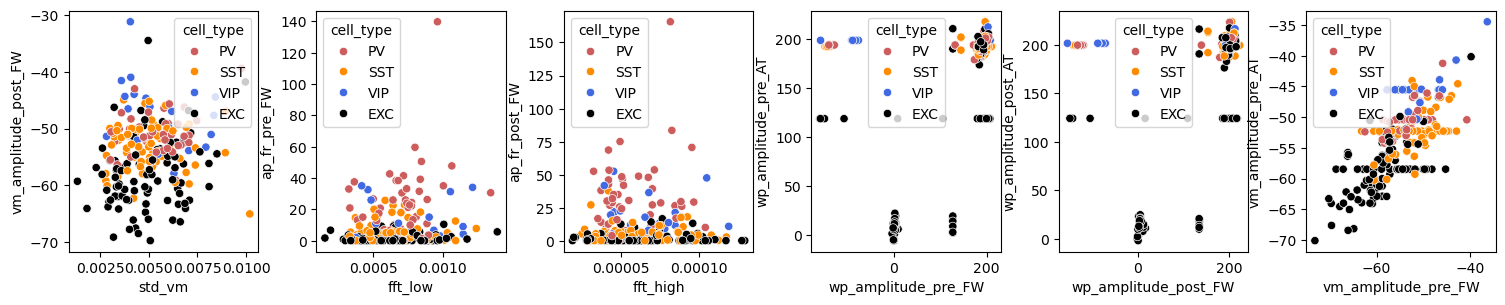

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=(15, 3))
fig.tight_layout()
for i in range(6) :
    sns.scatterplot(x =data.iloc[:,9+i],  y=data.iloc[:,15+i], hue = data['cell_type'], ax= ax[i], palette=class_color)
    ax[i].set_xlabel(data.columns[9+i])
    ax[i].set_ylabel(data.columns[15+i])


#### boxplot to assess the variability

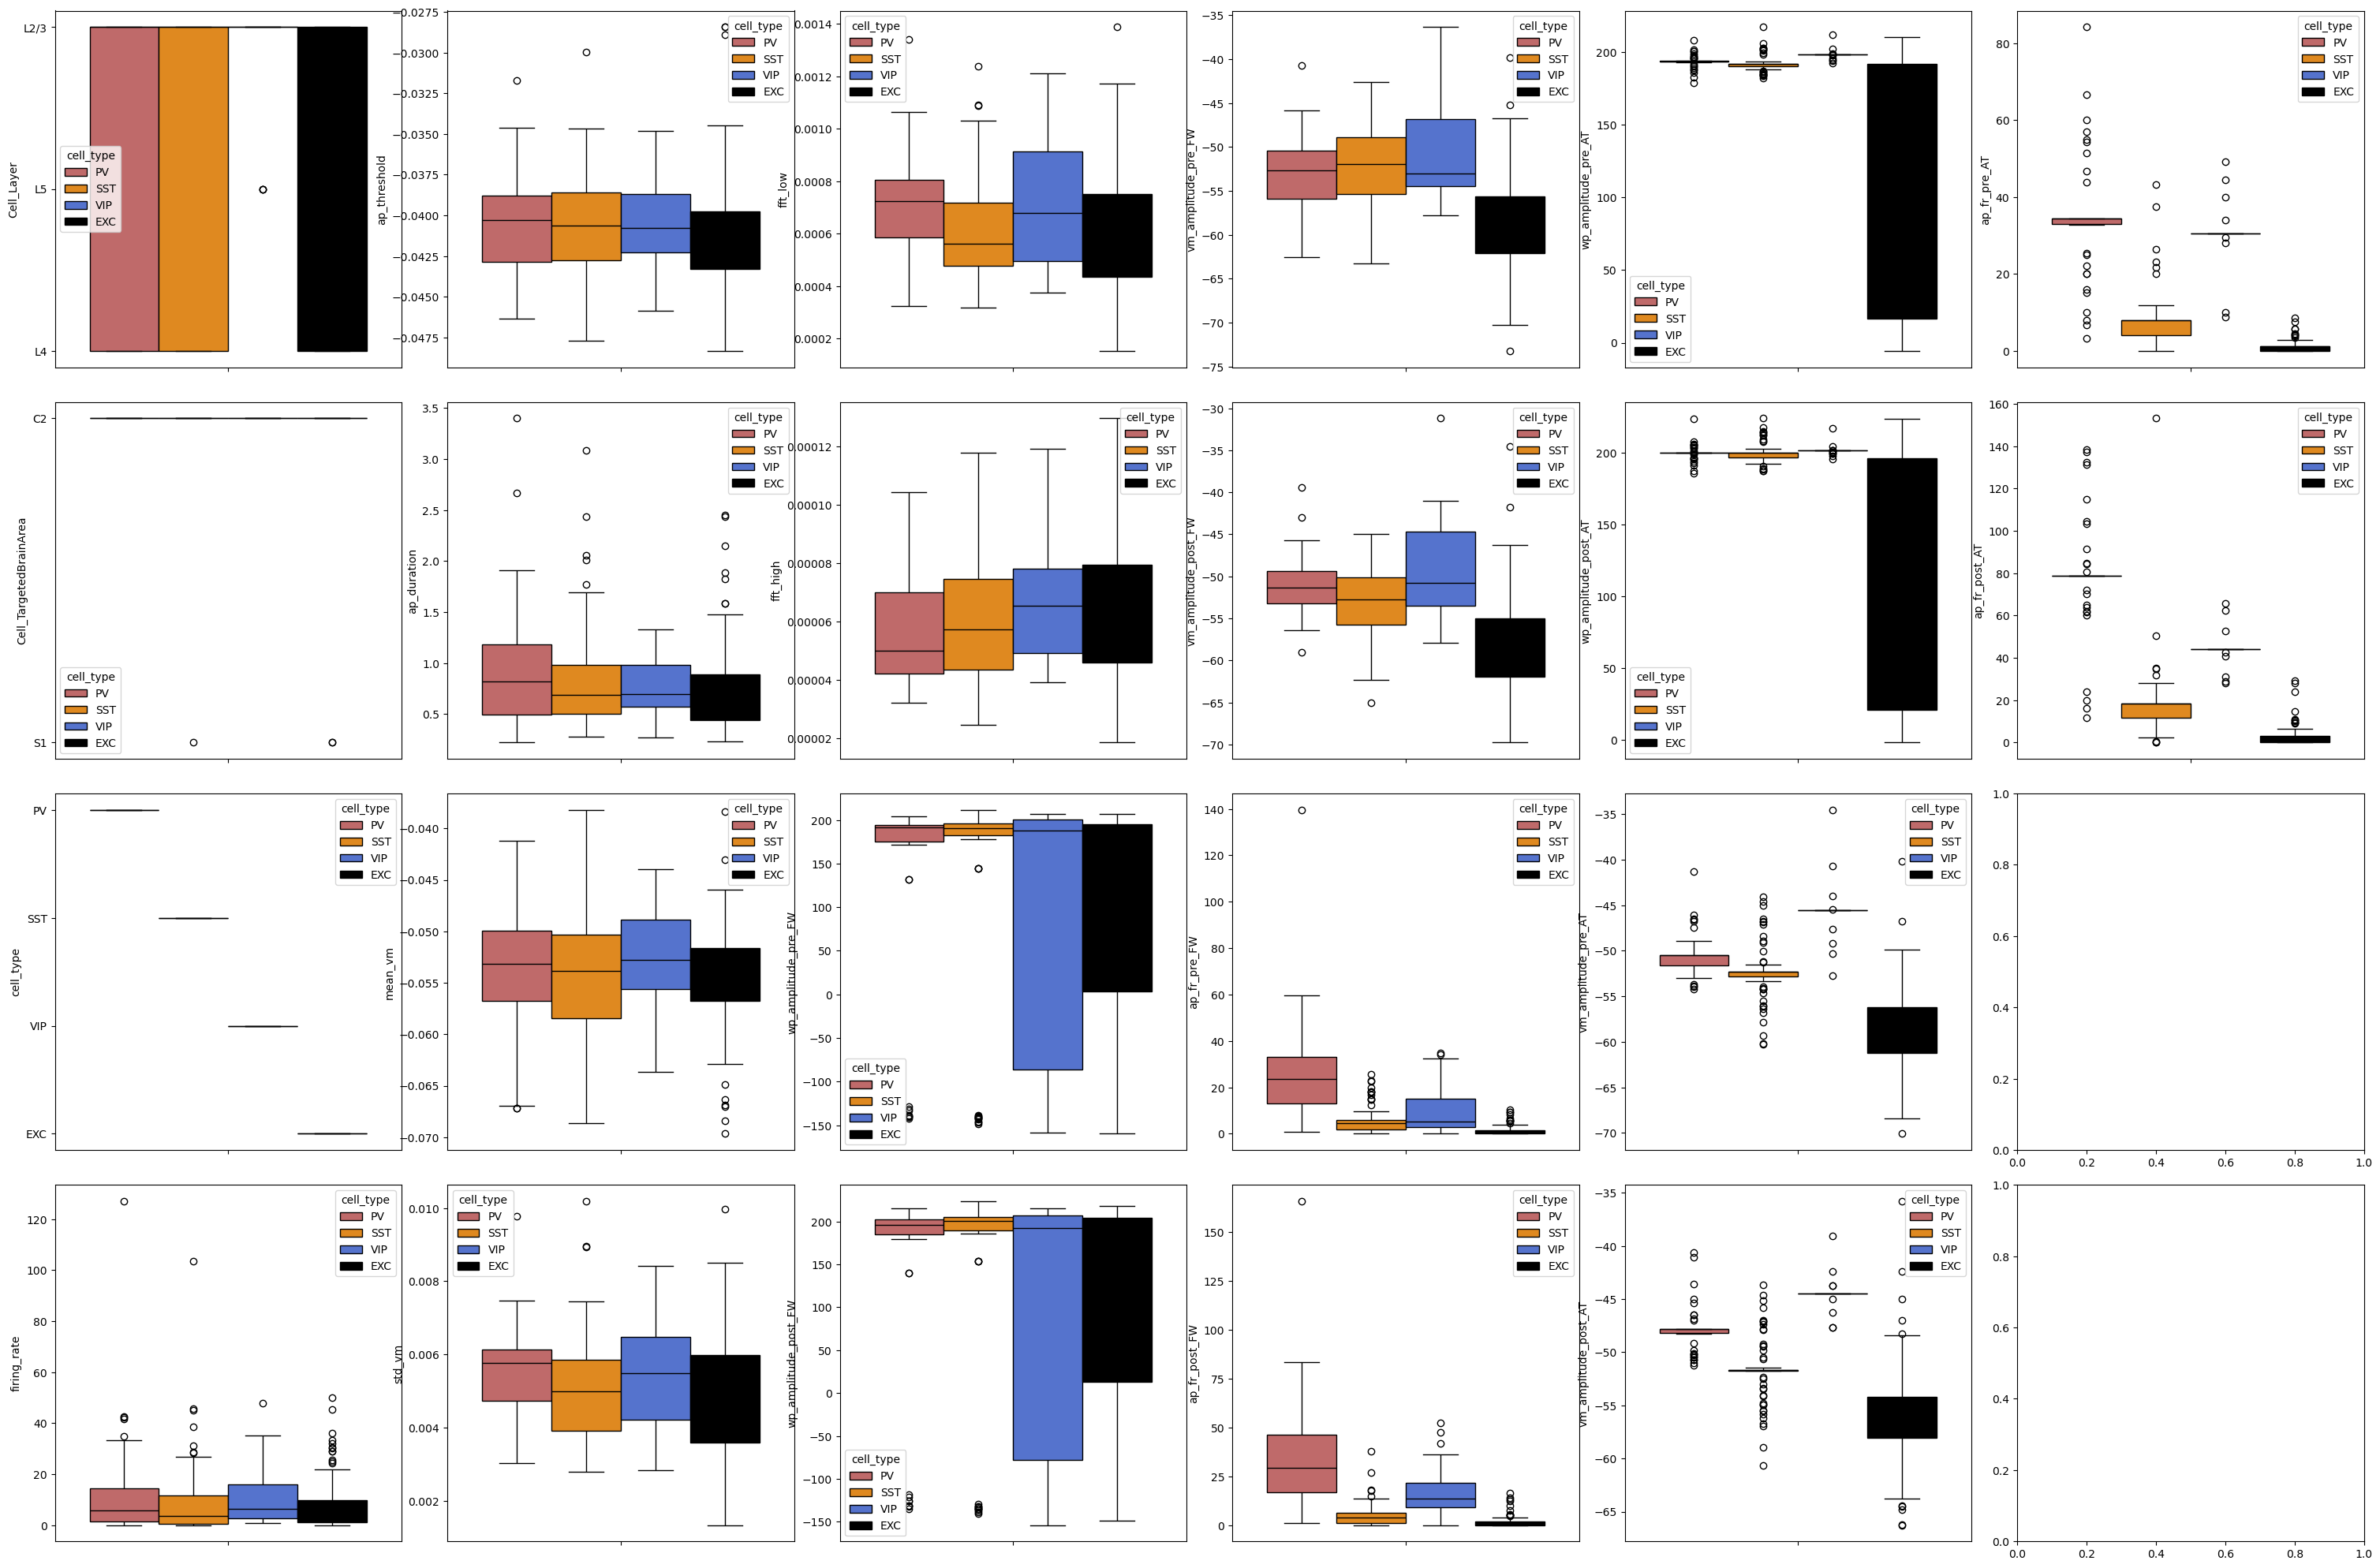

In [ ]:
fig, axs= plt.subplots(4, 6, figsize = (30, 20))
fig.tight_layout()

col_to_plot = list(data.columns[2:]).copy()

for i, col in enumerate(col_to_plot):

    sns.boxplot(data,y= col, ax=axs[int(i%4)][int(i/4)], hue = 'cell_type', palette=class_color)

#### Class balance

<Axes: xlabel='cell_type', ylabel='Count'>

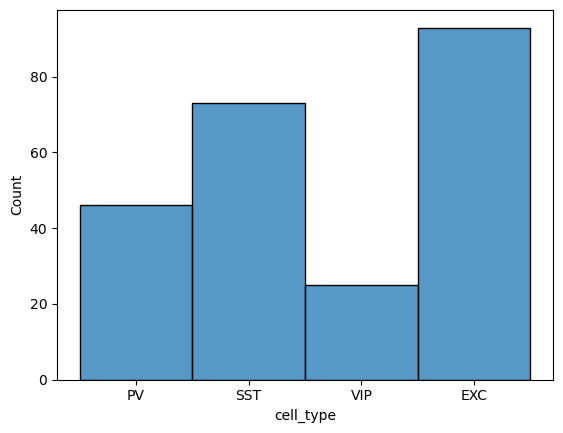

In [ ]:
sns.histplot(data['cell_type'])

## Transform categorical data into numerical ones with dummies

In [118]:
######## Class label ###########
y = data.cell_type

# Numerical encoding

label_map = {'EXC':0,'PV' : 10, 'VIP' : 11, 'SST' :12} # you can change the label as you prefer here
y_all = y.map(label_map)

######## Feature matrix ###########
X = data.copy()
X = X.drop(columns = ['cell_type', 'cell_id']) # drop the labels, drop the cell_id (we don't want them)

# Numerical encoding
X = pd.get_dummies(X) * 1

In [119]:
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import StandardScaler


x_train_all, x_test_all, y_train_all, y_test_all = train_test_split(StandardScaler().fit_transform(X.to_numpy()), y_all.to_numpy(), test_size=0.2, stratify=y_all)
y_train_bin=np.where(y_train_all==0,0,1)
y_test_bin=np.where(y_test_all==0,0,1)

inhib_id_train=np.argwhere(y_train_all!=0).ravel()
inhib_id_test=np.argwhere(y_test_all!=0).ravel()
x_train_inhib=x_train_all[inhib_id_train]
y_train_inhib=y_train_all[inhib_id_train]
y_test_inhib=y_test_all[inhib_id_test]



In [120]:
#classification weights
def weightsdet(y_train):
       # 1. Calculate the class frequencies (counts of each class)
       class_counts = Counter(y_train)
       total_samples = len(y_train)
       # 2. Calculate class weights based on the inverse of the class frequencies
       return {cls: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}

weights_bin=weightsdet(y_train_bin)
print(weights_bin)
weights_inhib=weightsdet(y_train_inhib)
print(weights_inhib)

{1: 0.8217391304347826, 0: 1.277027027027027}
{12: 0.6609195402298851, 11: 1.9166666666666667, 10: 1.0360360360360361}


## 3. PCA

In [121]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def pca(x,y, component_vis=None, X_columns=X.columns, threshold=1):
    pca=PCA()
    x_pca=pca.fit_transform(x)
    print(pca.explained_variance_ratio_)
    # Plot the Scree plot
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
    plt.title('Scree Plot')
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.xticks(np.arange(1, len(pca.explained_variance_ratio_) + 1))
    plt.grid(True)
    plt.show()

    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    print(cumulative_variance)
    plt.bar(x=range(1,len(cumulative_variance )+1),height=np.round(cumulative_variance* 100,decimals=1))
    plt.ylabel('Percentage of Explained Variance')
    plt.xlabel('Principal Components')
    plt.title('Cumulative variance')
    plt.show()
    # Find the number of components needed to reach 98% explained variance

    num_components = np.argmax(cumulative_variance >= 1-1e-9) + 1
    print(f"Number of components to retain {threshold*100}% variance: {num_components}")
    vis_comp= num_components if component_vis==None else component_vis
    if np.size(vis_comp)==1:
        x_vis=x_pca[:, :vis_comp]
        pca_columns = [f'PC{i+1}' for i in range(vis_comp)]
    else:
        x_vis=x_pca[:, np.array(vis_comp)+1]
        pca_columns = [f'PC{i}' for i in vis_comp]
    # Create a DataFrame for the reduced PCA data

    X_pca_df = pd.DataFrame(x_vis, columns=pca_columns)

    display(X_pca_df)
    # Add the labels to the DataFrame
    X_pca_df['Label'] = y # Ensure 'y' is aligned with the data and categorical if needed


    # Pair plot
    if len(np.unique(y)) == 2 : palette = {0:'k', 1:'r'}
    if len(np.unique(y)) == 3 : palette = {10: 'indianred', 11: 'royalblue', 12: 'darkorange'}
    if len(np.unique(y)) == 4 : palette = {0: 'k', 10: 'indianred', 11: 'royalblue', 12: 'darkorange'}

    sns.set(style="ticks")
    pairplot = sns.pairplot(X_pca_df, hue='Label', diag_kind='hist',palette=palette, markers=['o', 's'])

    plt.show()
    pca_loadings = pca.components_[:num_components]  # Loadings for the retained components
    pca_loadings_df = pd.DataFrame(
        pca_loadings.T,  # Transpose to align features with components
        columns=[f'PC{i+1}' for i in range(num_components)],
        index=X_columns  # Use feature names as the index
    )

    low_contribution_threshold = 0.1
    low_contributing_features = pca_loadings_df[(pca_loadings_df.abs() < low_contribution_threshold).all(axis=1)]

    print("Low-contributing features:")
    print(low_contributing_features.index.tolist())

    plt.figure(figsize=(30, 10))
    sns.heatmap(pca_loadings_df, annot=True, cmap='coolwarm', cbar=True)
    plt.title("PCA Loadings (Feature Contributions)")
    plt.xlabel("Principal Components")
    plt.ylabel("Original Features")
    plt.show()

    return x_pca[:, :num_components],[X.columns.get_loc(feature) for feature in low_contributing_features.index.tolist() if feature in X.columns], pca




[2.24028485e-01 1.44817176e-01 1.09940281e-01 9.57395638e-02
 7.52750964e-02 6.50578183e-02 6.14570301e-02 5.01196044e-02
 4.21795597e-02 3.37244817e-02 2.33188857e-02 2.24718257e-02
 1.39133087e-02 1.02761615e-02 8.30394792e-03 5.49209985e-03
 4.97560424e-03 3.88313329e-03 2.06620636e-03 1.56928061e-03
 1.33802591e-03 3.13756841e-05 2.10486886e-05 2.04612099e-33
 1.38453349e-33]


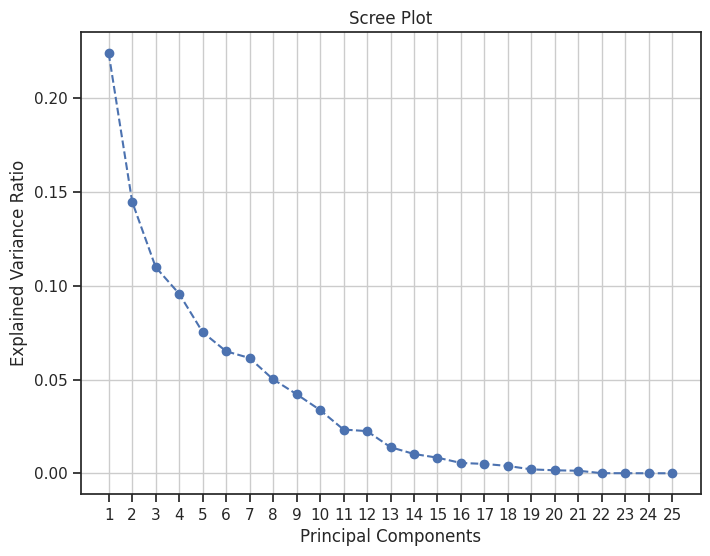

[0.22402849 0.36884566 0.47878594 0.57452551 0.6498006  0.71485842
 0.77631545 0.82643505 0.86861461 0.9023391  0.92565798 0.94812981
 0.96204312 0.97231928 0.98062323 0.98611533 0.99109093 0.99497406
 0.99704027 0.99860955 0.99994758 0.99997895 1.         1.
 1.        ]


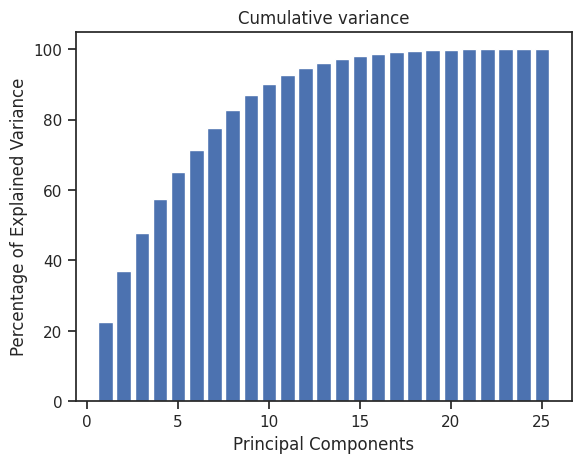

Number of components to retain 100% variance: 23


PC1       PC2
0    2.485485  1.824653
1   -1.962195 -1.934806
2   -0.969449 -2.332223
3    2.794616 -0.716269
4    2.785769  0.780886
..        ...       ...
184  0.465348 -0.851327
185  2.663376 -2.121071
186 -0.232297  0.934813
187 -1.344382  0.912989
188 -1.189572  1.609472

[189 rows x 2 columns]

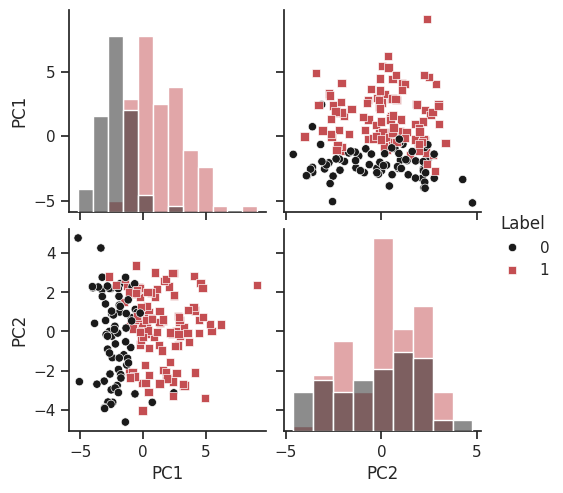

Low-contributing features:
[]


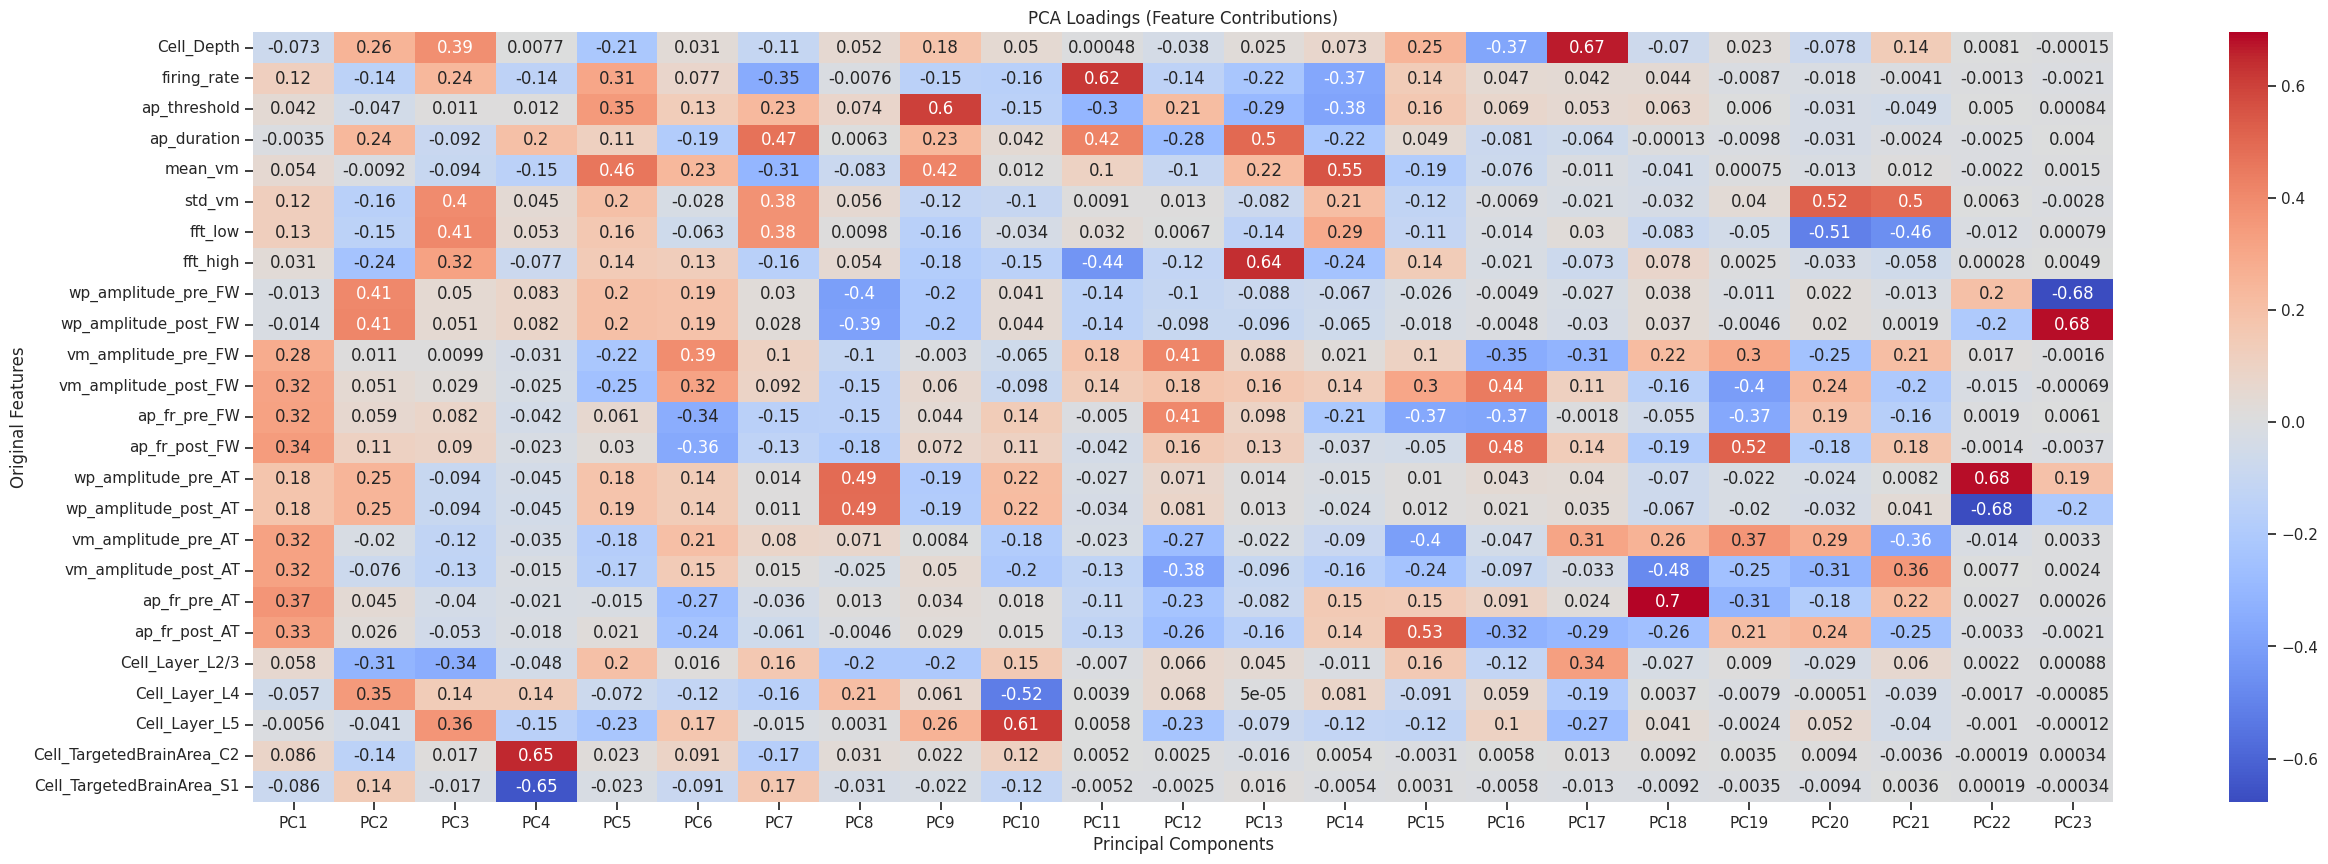

In [122]:
x_pca_bin, low_feat_bin, pca_all=pca(x_train_all,y_train_bin, component_vis=2,threshold=1)
x_test_pca_bin=pca_all.transform(x_test_all)[:,:23]

[2.26809008e-01 1.74458313e-01 1.10476749e-01 9.64658506e-02
 7.68377630e-02 6.84456305e-02 5.95069453e-02 4.06784384e-02
 3.48863565e-02 2.86082701e-02 2.09172421e-02 1.83622430e-02
 1.07773602e-02 9.87293108e-03 7.74666409e-03 5.96408097e-03
 4.17619394e-03 2.19268724e-03 1.61590223e-03 7.72244156e-04
 3.81073055e-04 2.80722029e-05 1.99819656e-05 1.24651565e-33
 6.48044707e-34]


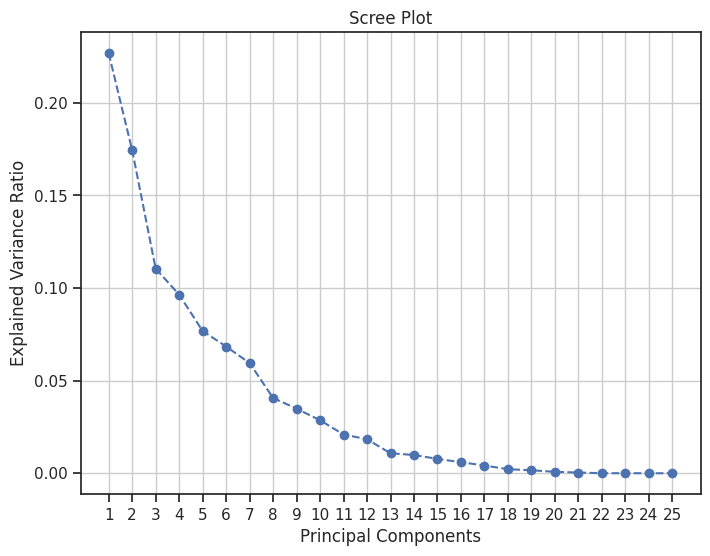

[0.22680901 0.40126732 0.51174407 0.60820992 0.68504768 0.75349331
 0.81300026 0.8536787  0.88856505 0.91717332 0.93809057 0.95645281
 0.96723017 0.9771031  0.98484976 0.99081385 0.99499004 0.99718273
 0.99879863 0.99957087 0.99995195 0.99998002 1.         1.
 1.        ]


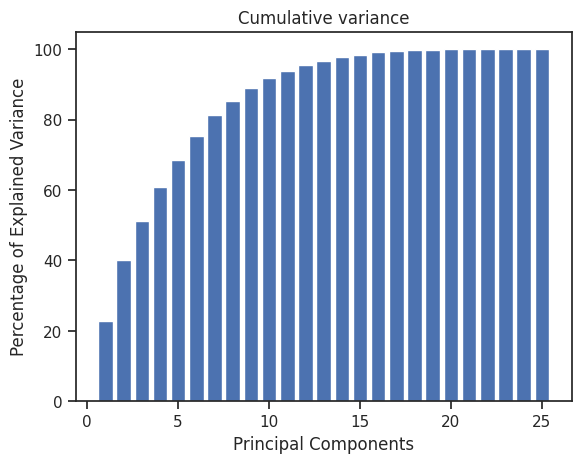

Number of components to retain 100% variance: 23


PC1      PC13
0    0.035648 -0.760189
1   -1.298303  0.051670
2    1.144675 -1.132256
3   -1.634386  0.465711
4    3.895204  0.004379
..        ...       ...
110 -1.341083 -0.010525
111  0.045951 -0.067716
112 -0.094021  0.287259
113  2.474282  0.496654
114 -1.348200  0.394199

[115 rows x 2 columns]

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)


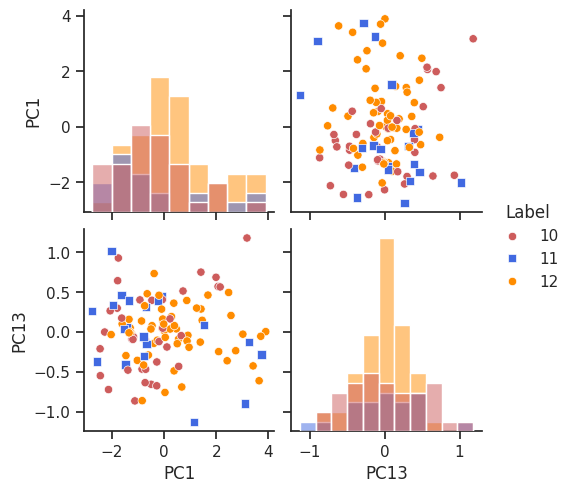

Low-contributing features:
[]


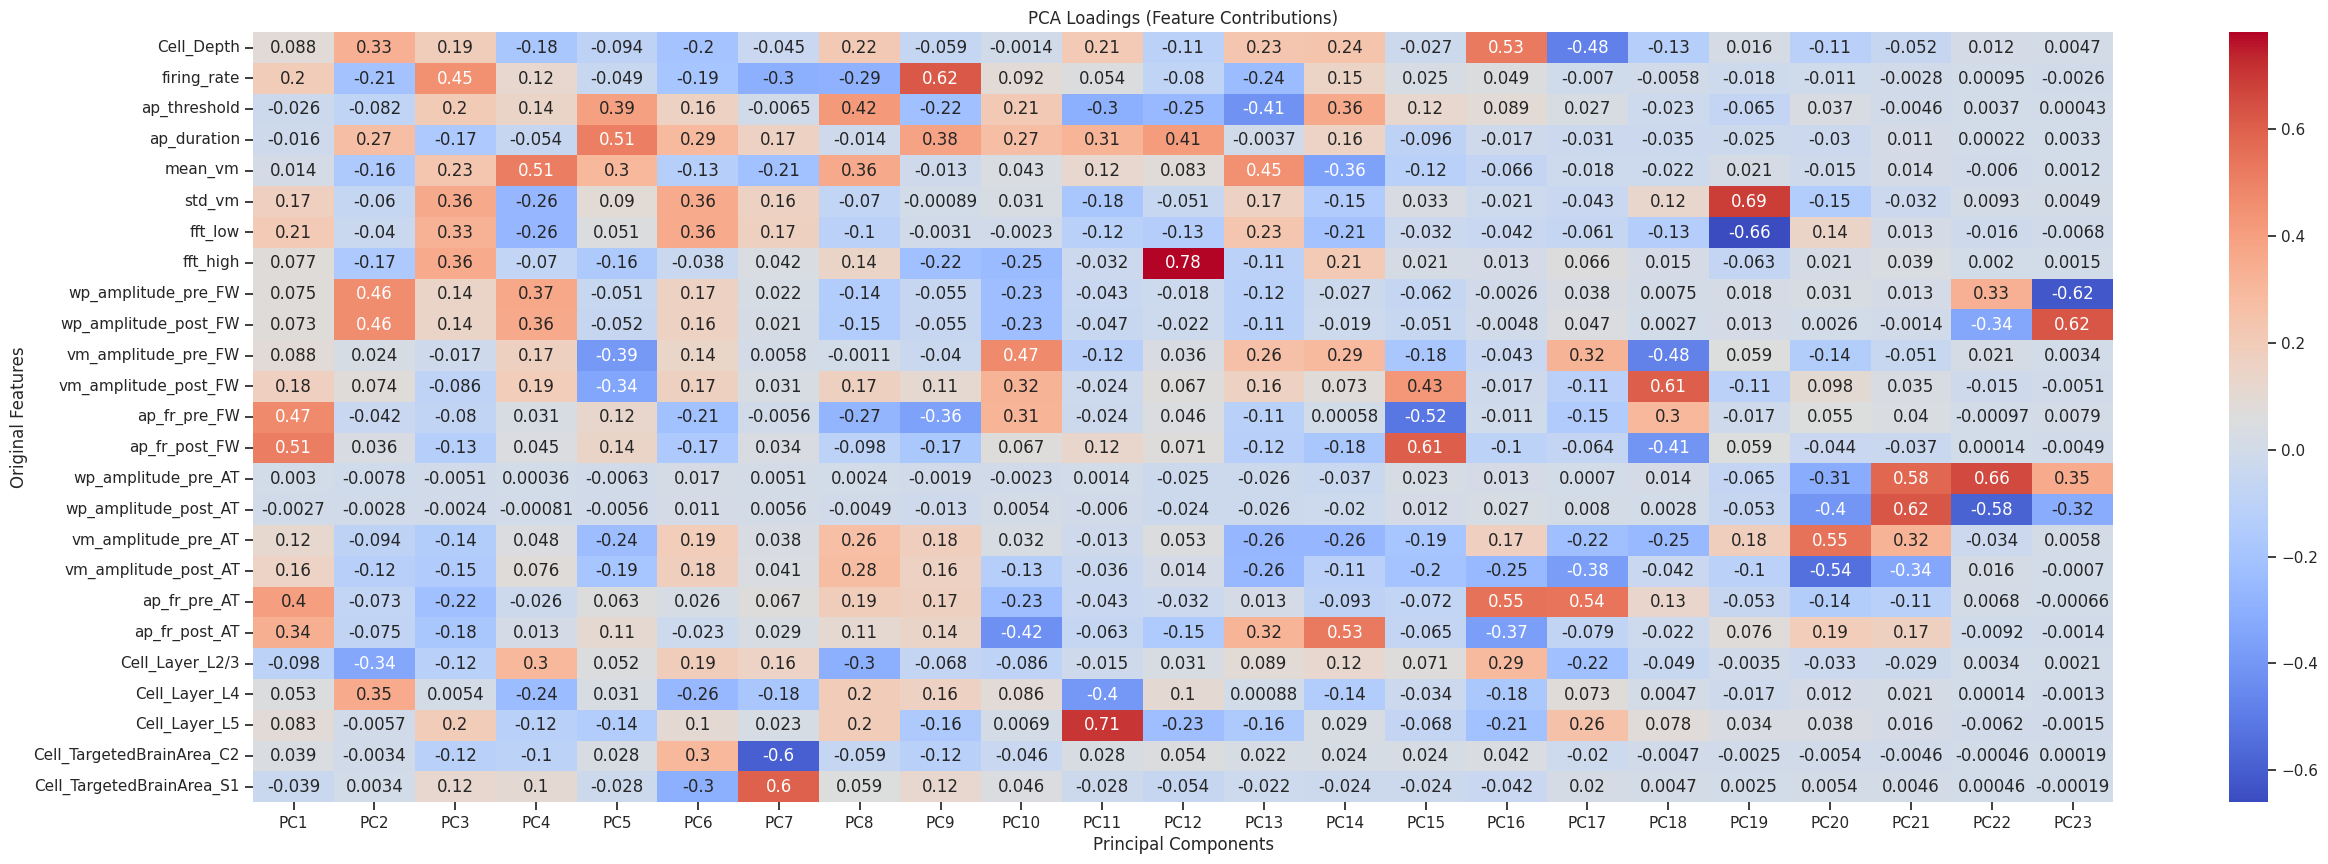

In [123]:
x_pca_inhib,  low_feat_inhib,_=pca(x_train_inhib,y_train_inhib, component_vis=[1,13])

[2.26809008e-01 1.74458313e-01 1.10476749e-01 9.64658506e-02
 7.68377630e-02 6.84456305e-02 5.95069453e-02 4.06784384e-02
 3.48863565e-02 2.86082701e-02 2.09172421e-02 1.83622430e-02
 1.07773602e-02 9.87293108e-03 7.74666409e-03 5.96408097e-03
 4.17619394e-03 2.19268724e-03 1.61590223e-03 7.72244156e-04
 3.81073055e-04 2.80722029e-05 1.99819656e-05 9.65251386e-34
 3.87403997e-34]


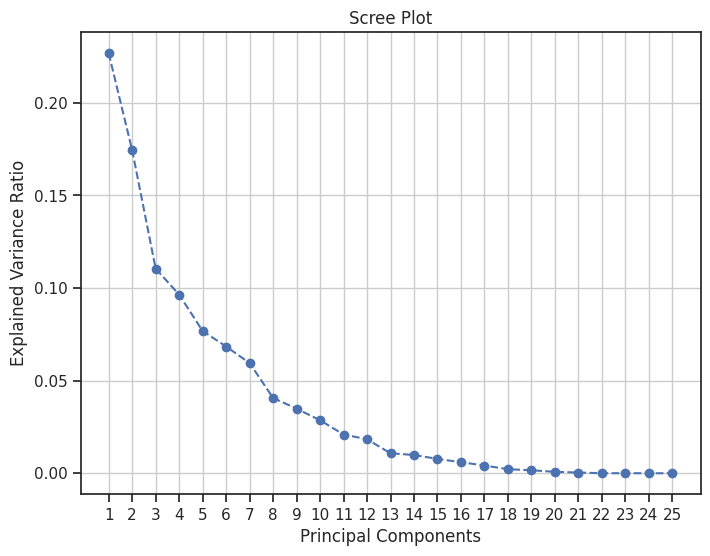

[0.22680901 0.40126732 0.51174407 0.60820992 0.68504768 0.75349331
 0.81300026 0.8536787  0.88856505 0.91717332 0.93809057 0.95645281
 0.96723017 0.9771031  0.98484976 0.99081385 0.99499004 0.99718273
 0.99879863 0.99957087 0.99995195 0.99998002 1.         1.
 1.        ]


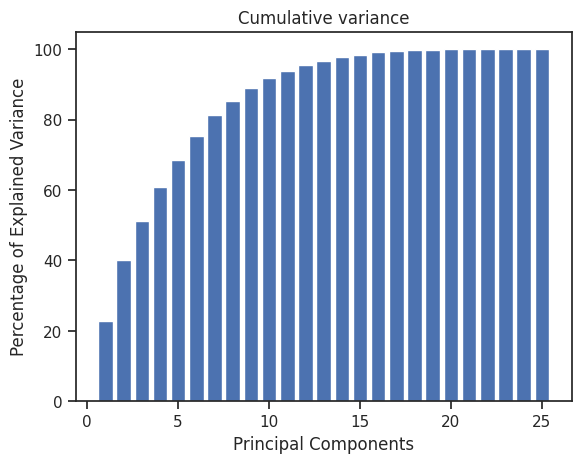

Number of components to retain 100% variance: 23


PC1       PC2
0    1.374001  1.749556
1   -2.978668 -2.394622
2    1.089509 -1.176399
3    0.043799  0.279228
4   -1.508882 -4.116384
..        ...       ...
110 -3.013387 -2.647252
111 -0.838810  2.286852
112 -1.263111  2.264256
113 -0.739580 -0.122112
114 -0.219126 -2.638120

[115 rows x 2 columns]

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)


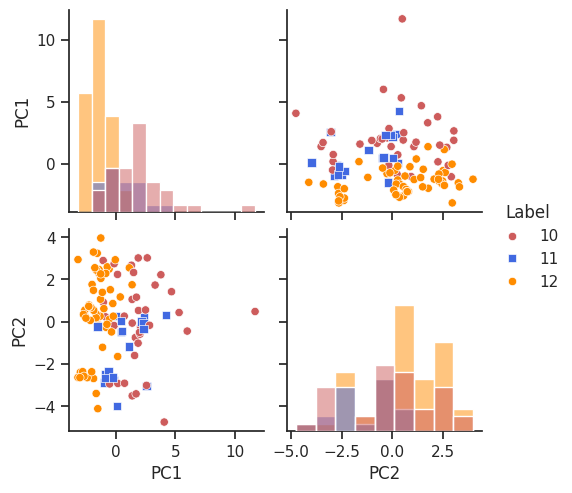

Low-contributing features:
[]


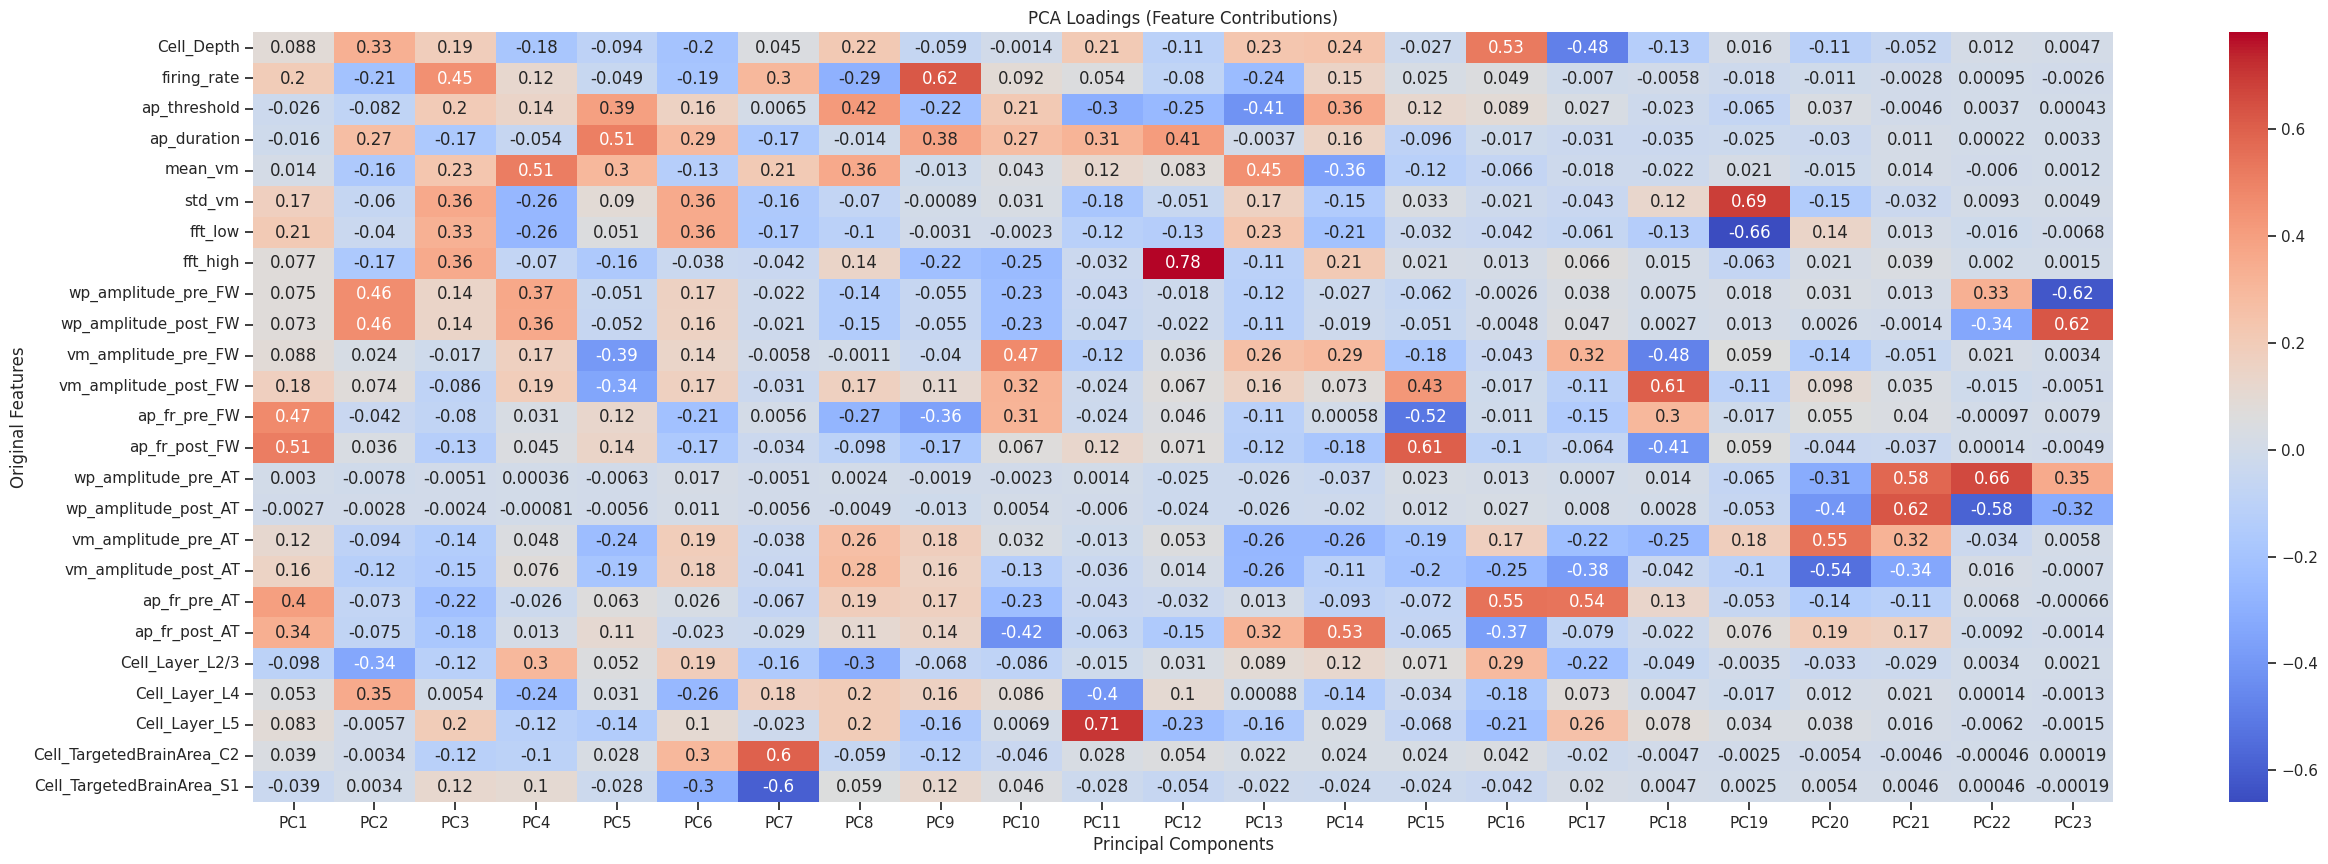

In [124]:
x_pca_inhib, _, pca_inhib=pca(np.delete(x_train_inhib, low_feat_inhib, axis=1),y_train_inhib, component_vis=2, X_columns=np.delete(X.columns, low_feat_inhib))
x_pca_inhib_all=pca_inhib.transform(np.delete(x_train_all, low_feat_inhib, axis=1))[:,:23]
x_test_pca_inhib=pca_all.transform(np.delete(x_test_all, low_feat_inhib, axis=1))[:,:23]

## 4. LDA

In [125]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

def lda(x,y, component_vis=None, X_columns=X.columns):
    lda=LDA()
    x_lda=lda.fit_transform(x,y)
    if x_lda.shape[1]>1:
        X_lda_df = pd.DataFrame(x_lda, columns=[f'C{i+1}' for i in range(x_lda.shape[1])])

        display(X_lda_df)
        # Add the labels to the DataFrame
        X_lda_df['Label'] = y # Ensure 'y' is aligned with the data and categorical if needed


        # Pair plot
        sns.set(style="ticks")
        if len(np.unique(y)) == 2 : palette = {0:'k', 1:'r'}
        if len(np.unique(y)) == 3 : palette = {10: 'indianred', 11: 'royalblue', 12: 'darkorange'}
        if len(np.unique(y)) == 4 : palette = {0: 'k', 10: 'indianred', 11: 'royalblue', 12: 'darkorange'}

        pairplot = sns.pairplot(X_lda_df, hue='Label', diag_kind='hist',palette=palette, markers=['o', 's'])
        plt.show()
    return x_lda, lda



In [126]:
x_lda_bin, lda_bin=lda(x_train_all,y_train_bin, component_vis=None, X_columns=X.columns)

display(x_lda_bin)

array([[ 2.88385185],
       [-2.71395562],
       [ 1.31731761],
       [ 1.58753821],
       [ 1.94817856],
       [ 1.5537727 ],
       [ 1.56844506],
       [ 0.20048911],
       [-1.07029311],
       [-0.11970553],
       [-2.41614132],
       [-1.32306011],
       [ 1.94969637],
       [-1.87380361],
       [ 1.06325773],
       [-2.02946273],
       [-1.6867782 ],
       [ 1.77301794],
       [ 1.52384724],
       [-3.05551862],
       [ 1.73620255],
       [-3.05940694],
       [-0.92624251],
       [ 2.4639758 ],
       [-1.65139305],
       [ 0.51603123],
       [-0.56337868],
       [ 1.10776045],
       [-1.14247894],
       [ 0.96679433],
       [ 1.25735809],
       [ 0.4857621 ],
       [ 2.41257998],
       [-0.34002852],
       [ 1.45946635],
       [ 1.83052427],
       [ 1.8524712 ],
       [ 0.82117136],
       [-0.96890697],
       [ 1.12250572],
       [ 2.94114364],
       [ 3.20681778],
       [-2.02802919],
       [-3.73777102],
       [-2.81636903],
       [ 2

C1        C2
0    1.197530 -1.017328
1    2.304289 -0.616006
2   -2.252581 -2.654414
3   -3.267048 -2.629370
4    1.714827 -0.499488
..        ...       ...
110  2.104242 -0.789531
111  1.950978 -0.419824
112  1.538492 -0.256477
113  1.220934 -0.244301
114 -3.101965 -2.358734

[115 rows x 2 columns]

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)


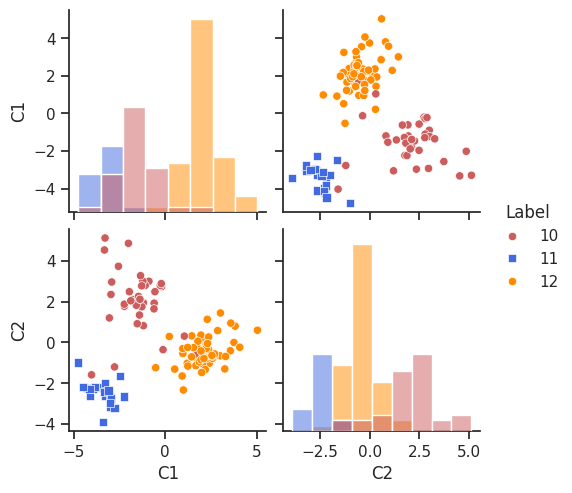

In [127]:
x_lda_inhib, lda_inhibitory =lda(x_train_inhib,y_train_inhib, component_vis=None, X_columns=X.columns)

## 5 . Classification

In [128]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

### hyperparameter selection

In [129]:
from sklearn.model_selection import GridSearchCV

#### first

In [130]:

param_grid_svc = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.001, 0.01, 0.1, 1, 10,100],
    'gamma': [0.0001, 0.001, 0.01, 0.1]  # Used for 'rbf' and 'poly'
}

svc = SVC()
grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5, scoring='accuracy')
grid_search_svc.fit(x_train_all,y_train_bin)
svc_params=grid_search_svc.best_params_
print(svc_params, x_train_all.shape)

grid_search_svc.fit(x_pca_bin,y_train_bin)
svc_params_pca=grid_search_svc.best_params_
print(svc_params_pca, x_pca_bin.shape)

grid_search_svc.fit(x_lda_bin,y_train_bin)
svc_params_lda=grid_search_svc.best_params_
print(svc_params_lda, x_lda_bin.shape)

{'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'} (189, 25)
{'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'} (189, 23)
{'C': 0.01, 'gamma': 0.0001, 'kernel': 'linear'} (189, 1)


In [131]:
print(cross_val_score(SVC(**svc_params),x_train_all,y_train_bin, cv=5).mean())
print(cross_val_score(SVC(**svc_params_pca),x_pca_bin,y_train_bin, cv=5).mean())
print(cross_val_score(SVC(**svc_params_lda),x_lda_bin,y_train_bin,cv=5).mean())

0.9261735419630156
0.9261735419630156
0.947226173541963


In [132]:
param_grid_knn = {
    'n_neighbors': [1, 3, 5, 10, 20,30,40,50,100],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy')

In [133]:
grid_search_knn.fit(x_train_all,y_train_bin)
knn_params=grid_search_knn.best_params_
print(knn_params, x_train_all.shape)
grid_search_knn.fit(x_pca_bin,y_train_bin)
knn_params_pca=grid_search_knn.best_params_
print(knn_params_pca, x_pca_bin.shape)
grid_search_knn.fit(x_lda_bin,y_train_bin)
knn_params_lda=grid_search_knn.best_params_
print(knn_params_lda, x_lda_bin.shape)

{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'} (189, 25)
{'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'} (189, 23)
{'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'uniform'} (189, 1)


In [134]:
print(cross_val_score(KNeighborsClassifier(**knn_params),x_train_all,y_train_bin, cv=5).mean())
print(cross_val_score(KNeighborsClassifier(**knn_params_pca),x_pca_bin,y_train_bin, cv=5).mean())
print(cross_val_score(KNeighborsClassifier(**knn_params_lda),x_lda_bin,y_train_bin, cv=5).mean())

0.9470839260312944
0.9155049786628734
0.947226173541963


#### 2nd

In [135]:
param_grid_knn = {
    'n_neighbors': [1, 3, 5, 10,20,30,],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(x_train_inhib,y_train_inhib)
knn_params_inhib=grid_search_knn.best_params_
print(knn_params_inhib, x_train_inhib.shape)
grid_search_knn.fit(x_pca_inhib,y_train_inhib)
knn_params_pca_inhib=grid_search_knn.best_params_
print(knn_params_pca_inhib, x_pca_inhib.shape)
grid_search_knn.fit(x_lda_inhib,y_train_inhib)
knn_params_lda_inhib=grid_search_knn.best_params_
print(knn_params_lda_inhib, x_lda_inhib.shape)

{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'} (115, 25)
{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'} (115, 23)
{'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'} (115, 2)


In [136]:
print(cross_val_score(KNeighborsClassifier(**knn_params_inhib),x_train_inhib,y_train_inhib, cv=5).mean())
print(cross_val_score(KNeighborsClassifier(**knn_params_pca_inhib),x_pca_inhib,y_train_inhib, cv=5).mean())
print(cross_val_score(KNeighborsClassifier(**knn_params_lda_inhib),x_lda_inhib,y_train_inhib, cv=5).mean())

0.8869565217391304
0.8869565217391304
0.9565217391304348


### Trainning

In [137]:
train_svc=SVC(**svc_params,class_weight=weights_bin, probability=True)
train_svc.fit(x_train_all,y_train_bin)
pickle.dump(train_svc, open('train_svc.sav', 'wb'))

train_svc_pca=SVC(**svc_params_pca,class_weight=weights_bin,probability=True)
train_svc_pca.fit(x_pca_bin,y_train_bin)
pickle.dump(train_svc_pca, open('train_svc_pca.sav', 'wb'))

train_svc_lda=SVC(**svc_params_lda,class_weight=weights_bin,probability=True)
train_svc_lda.fit(x_lda_bin,y_train_bin)
pickle.dump(train_svc_lda, open('train_svc_lda.sav', 'wb'))


In [138]:
train_knn=KNeighborsClassifier(**knn_params)
train_knn.fit(x_train_all,y_train_bin)
pickle.dump(train_knn, open('train_knn.sav', 'wb'))

train_knn_pca=KNeighborsClassifier(**knn_params_pca)
train_knn_pca.fit(x_pca_bin,y_train_bin)
pickle.dump(train_knn_pca, open('train_knn_pca.sav', 'wb'))

train_knn_lda=KNeighborsClassifier(**knn_params_lda)
train_knn_lda.fit(x_lda_bin,y_train_bin)
pickle.dump(train_knn_lda, open('train_knn_lda.sav', 'wb'))


In [139]:
train_knn_inhib=KNeighborsClassifier(**knn_params_inhib)
train_knn_inhib.fit(x_train_inhib,y_train_inhib)
pickle.dump(train_knn_lda, open('train_knn_inhib.sav', 'wb'))

train_knn_pca_inhib=KNeighborsClassifier(**knn_params_pca_inhib)
train_knn_pca_inhib.fit(x_pca_inhib,y_train_inhib)
pickle.dump(train_knn_lda, open('train_knn_pca_inhib.sav', 'wb'))

train_knn_lda_inhib=KNeighborsClassifier(**knn_params_lda_inhib)
train_knn_lda_inhib.fit(x_lda_inhib,y_train_inhib)
pickle.dump(train_knn_lda_inhib, open('train_knn_lda_inhib.sav', 'wb'))


### Classification

In [140]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

In [141]:
scores={}

0.9422222222222222
0.9422222222222222
0.9565217391304348


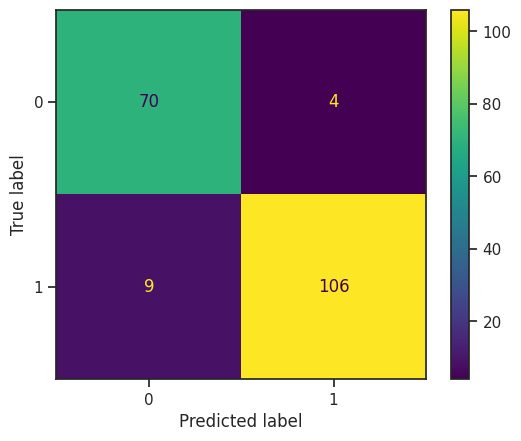

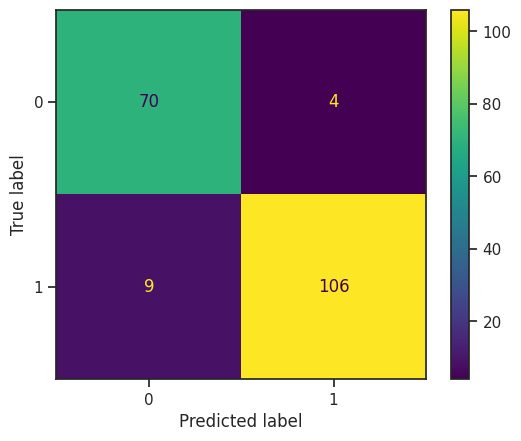

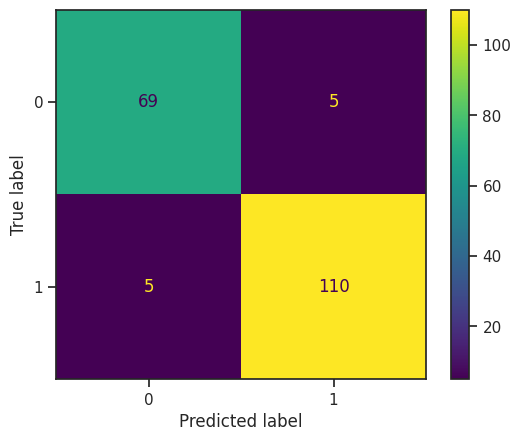

In [142]:
ConfusionMatrixDisplay(confusion_matrix(y_train_bin,train_svc.predict(x_train_all))).plot()
f1 = f1_score(y_train_bin,train_svc.predict(x_train_all))
print(f1)
scores['train_svc'] = f1

ConfusionMatrixDisplay(confusion_matrix(y_train_bin,train_svc_pca.predict(x_pca_bin))).plot()
f1 = f1_score(y_train_bin,train_svc_pca.predict(x_pca_bin))
print(f1)
scores['train_svc_pca'] = f1

ConfusionMatrixDisplay(confusion_matrix(y_train_bin,train_svc_lda.predict(x_lda_bin))).plot()
f1=f1_score(y_train_bin,train_svc_lda.predict(x_lda_bin))
print(f1)
scores['train_svc_lda'] = f1

1.0
0.9487179487179487
0.9519650655021834


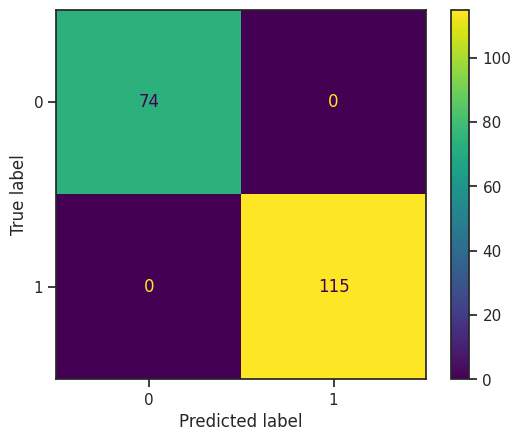

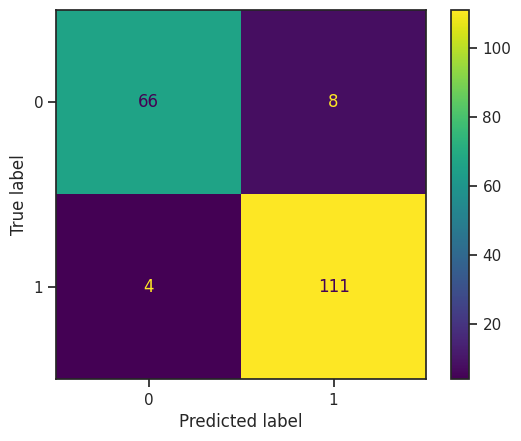

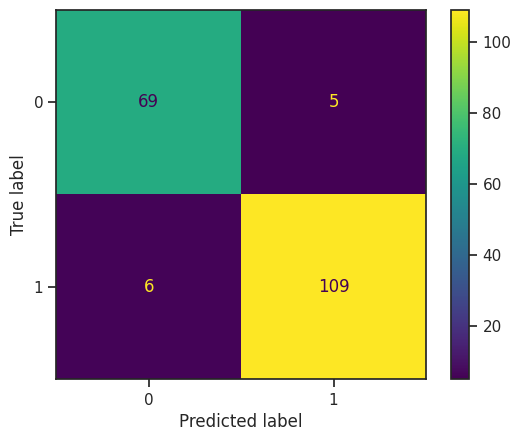

In [143]:
ConfusionMatrixDisplay(confusion_matrix(y_train_bin,train_knn.predict(x_train_all))).plot()
f1 = f1_score(y_train_bin,train_knn.predict(x_train_all))
print(f1)
scores['train_knn'] = f1

ConfusionMatrixDisplay(confusion_matrix(y_train_bin,train_knn_pca.predict(x_pca_bin))).plot()
f1 = f1_score(y_train_bin,train_knn_pca.predict(x_pca_bin))
print(f1)
scores['train_knn_pca'] = f1

ConfusionMatrixDisplay(confusion_matrix(y_train_bin,train_knn_lda.predict(x_lda_bin))).plot()
f1 = f1_score(y_train_bin,train_knn_lda.predict(x_lda_bin))
print(f1)
scores['train_knn_lda'] = f1


0.9130434782608695
0.9130434782608695
0.9565217391304348


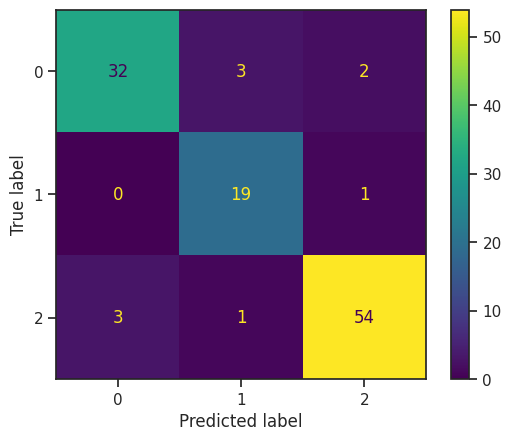

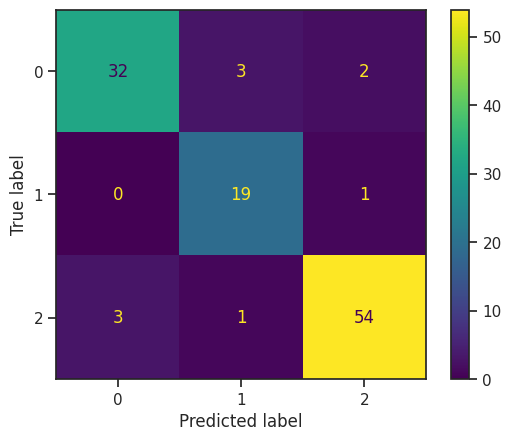

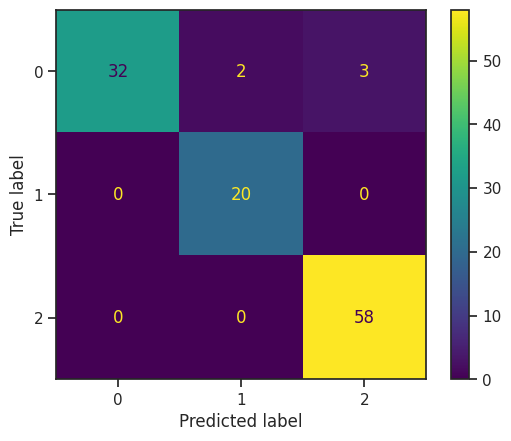

In [144]:
ConfusionMatrixDisplay(confusion_matrix(y_train_inhib,train_knn_inhib.predict(x_train_inhib))).plot()
f1 = f1_score(y_train_inhib,train_knn_inhib.predict(x_train_inhib), average='micro')
print(f1)
scores['train_knn_inhib'] = f1

ConfusionMatrixDisplay(confusion_matrix(y_train_inhib,train_knn_pca_inhib.predict(x_pca_inhib))).plot()
f1 = f1_score(y_train_inhib,train_knn_pca_inhib.predict(x_pca_inhib),average='micro')
print(f1)
scores['train_knn_pca_inhib'] = f1

ConfusionMatrixDisplay(confusion_matrix(y_train_inhib,train_knn_lda_inhib.predict(x_lda_inhib))).plot()
f1 = f1_score(y_train_inhib,train_knn_lda_inhib.predict(x_lda_inhib),average='micro')
print(f1)
scores['train_knn_lda_inhib'] = f1


#### overall algo prediction

0.8783068783068783

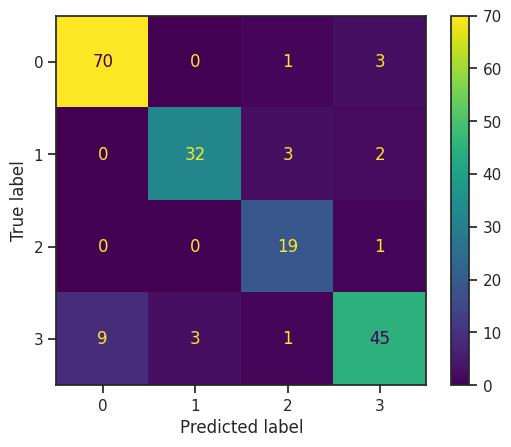

In [145]:
y_pred=train_svc_pca.predict(x_pca_bin)
id_pred=np.where(y_pred==1)[0]
y_pred[id_pred]=train_knn_pca_inhib.predict(x_pca_inhib_all[id_pred])
ConfusionMatrixDisplay(confusion_matrix(y_train_all,y_pred)).plot()
f1_score(y_train_all,y_pred, average='micro')

### TEST prediction

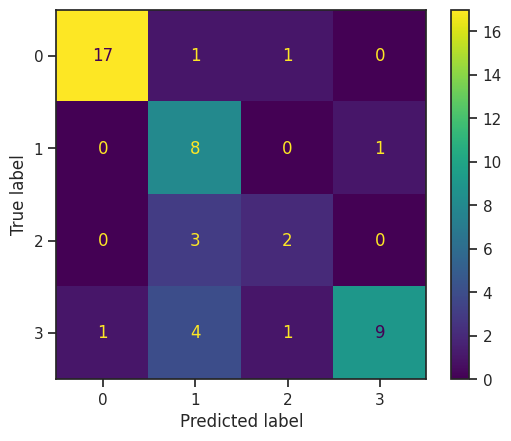

In [146]:
y_pred=train_svc_pca.predict(x_test_pca_bin)
id_pred=np.where(y_pred==1)[0]

y_pred[id_pred]=train_knn_pca_inhib.predict(x_test_pca_inhib[id_pred])

ConfusionMatrixDisplay(confusion_matrix(y_test_all,y_pred)).plot()

f1 = f1_score(y_test_all,y_pred, average='micro')
scores['test'] = f1

In [147]:
df_scores = pd.DataFrame(scores, index=[0], columns=scores.keys())

df_scores.to_csv('scores.csv')

### Data vizualization

<ipython-input-149-5e4b4763b21a>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(X.columns, rotation=45)
<ipython-input-149-5e4b4763b21a>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(X.columns, rotation=45)


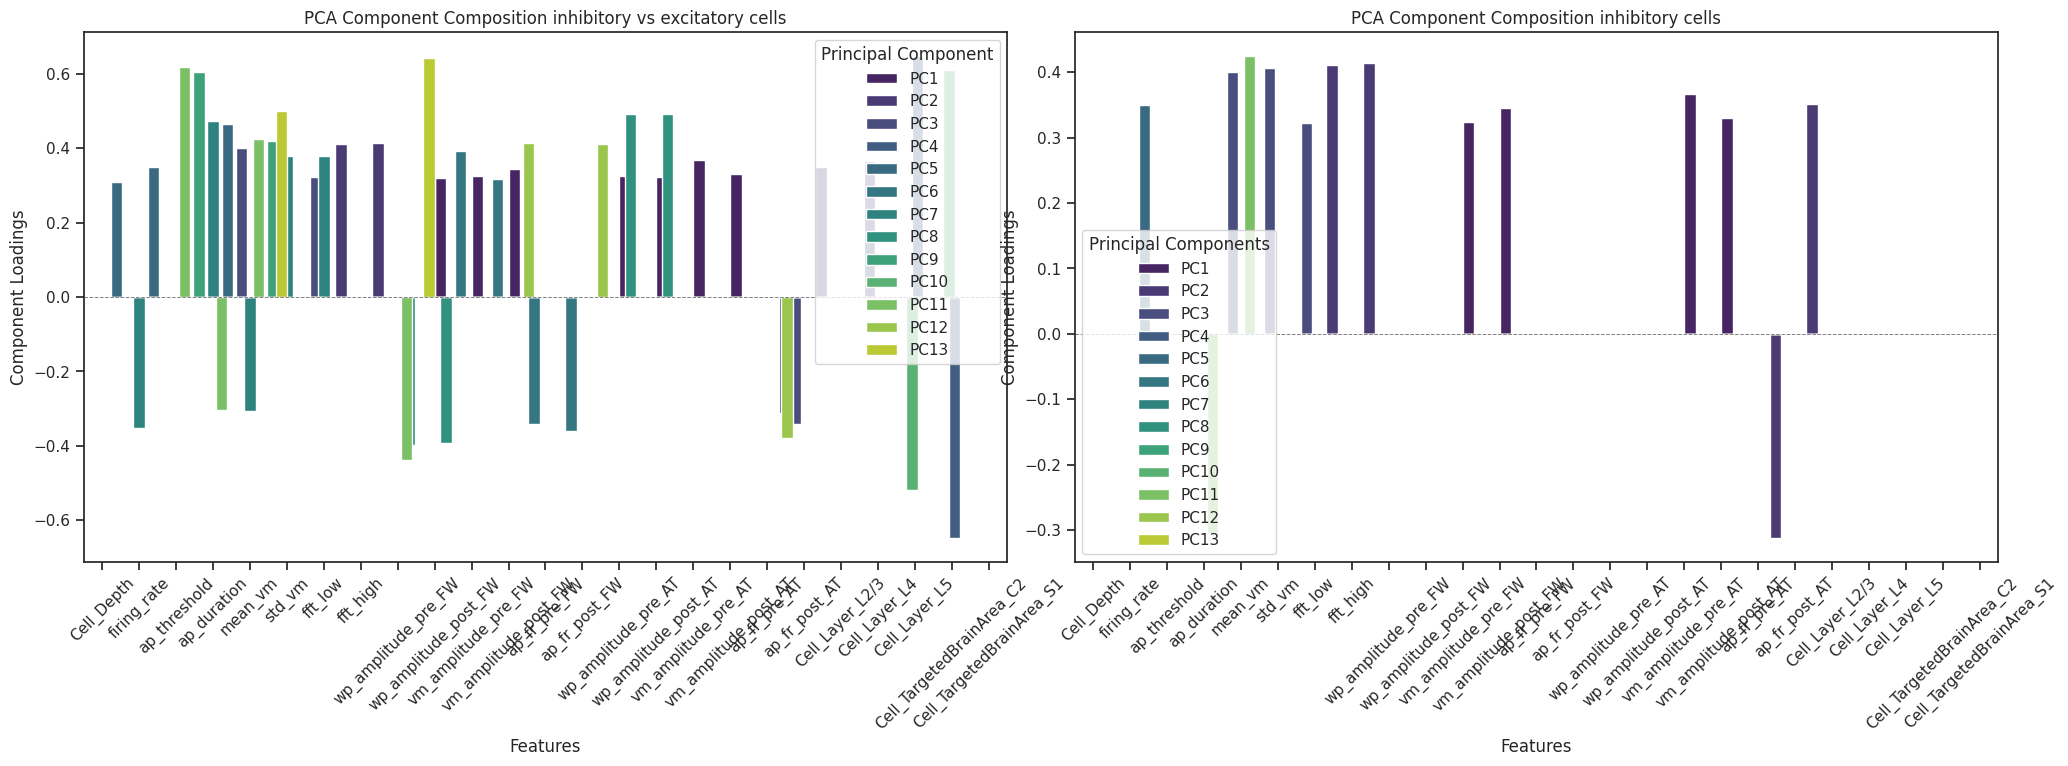

In [149]:
# PCA componants analysis
Compo_show = 13
thr = 0.3
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
fig.tight_layout()

# STEP 1 : binary classification
PCA_compo_bin = pca_all.components_[:Compo_show].T
PCA_compo_bin = np.where(abs(PCA_compo_bin) > thr, PCA_compo_bin, 0)

df_PCA_compo_bin = pd.DataFrame(PCA_compo_bin,columns=[f"PC{i+1}" for i in range(len(X.columns[:Compo_show]))],index=X.columns).reset_index()

df_melt_bin = df_PCA_compo_bin.melt(id_vars="index",var_name="Principal Component",value_name="Loading")

sns.barplot(data=df_melt_bin,x="index",y="Loading",hue="Principal Component",palette="viridis", ax=axs[0], width = 4)
axs[0].set_title("PCA Component Composition inhibitory vs excitatory cells")


# STEP 2 : inhibitory classification
PCA_compo_inhib = pca_inhib.components_[:Compo_show].T
PCA_compo_inhib = np.where(abs(PCA_compo_inhib) > thr, PCA_compo_bin, 0)

df_PCA_compo_inhib = pd.DataFrame(PCA_compo_inhib,columns=[f"PC{i+1}" for i in range(len(X.columns[:Compo_show]))],index=X.columns).reset_index()

df_melt_inhib = df_PCA_compo_inhib.melt(id_vars="index",var_name="Principal Component",value_name="Loading")

sns.barplot(data=df_melt_inhib,x="index",y="Loading",hue="Principal Component",palette="viridis", ax=axs[1], width=4)
axs[1].set_title("PCA Component Composition inhibitory cells")

# Formate
for ax in axs :
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.7)
    ax.set_xlabel("Features")
    ax.set_ylabel("Component Loadings")
    ax.set_xticklabels(X.columns, rotation=45)

axs[1].legend(title="Principal Components", loc='lower left')
plt.show()

<ipython-input-150-f487f446c22a>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(X.columns, rotation=45)
<ipython-input-150-f487f446c22a>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(X.columns, rotation=45)


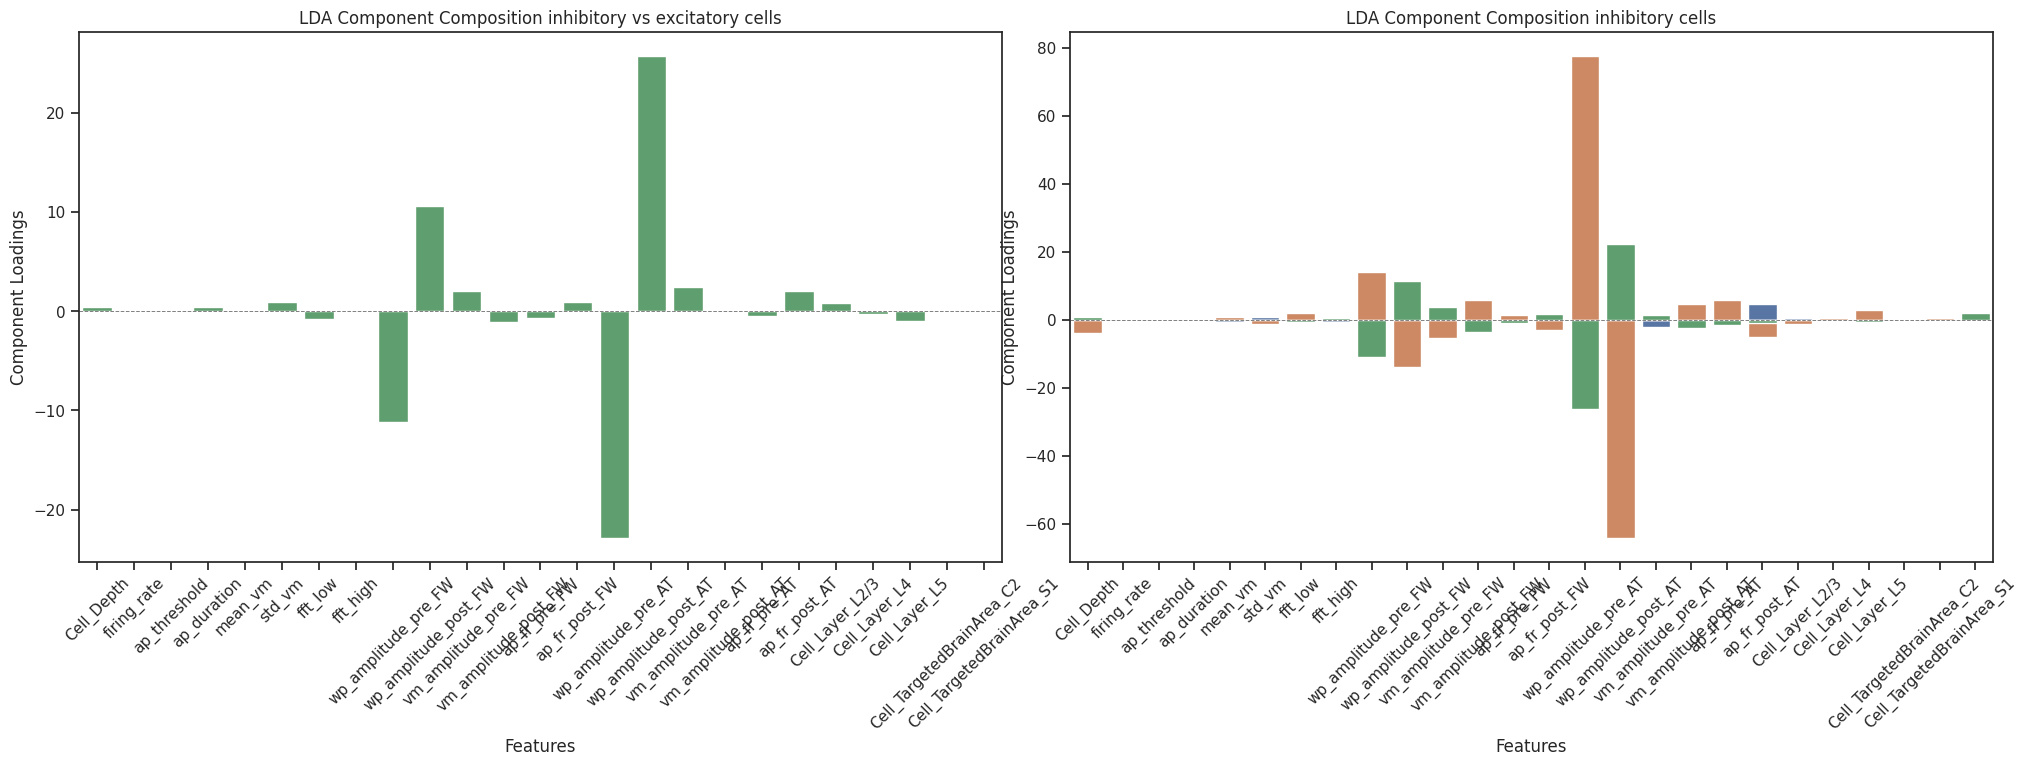

In [150]:
# LDA componants analysis
thr = 0.3
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
fig.tight_layout()

# STEP 1 : binary classification
LDA_compo_bin = lda_bin.coef_
LDA_compo_bin = np.where(abs(LDA_compo_bin) > thr, LDA_compo_bin, 0)
df_LDA_compo_bin = pd.DataFrame(LDA_compo_bin, columns = X.columns)

sns.barplot(data=df_LDA_compo_bin, ax=axs[0], color='g')
axs[0].set_title("LDA Component Composition inhibitory vs excitatory cells")


# STEP 2 : inhibitory classification
LDA_compo_inhib = lda_inhibitory.coef_[:Compo_show].T
LDA_compo_inhib = np.where(abs(LDA_compo_inhib) > thr, LDA_compo_inhib, 0)
df_LDA_compo_inhib = pd.DataFrame(LDA_compo_inhib.T, columns = X.columns)
df_LDA_compo_inhib['cluster'] = df_LDA_compo_inhib.index

sns.barplot(data=df_LDA_compo_inhib.iloc[0, :], ax=axs[1])
sns.barplot(data=df_LDA_compo_inhib.iloc[1, :], ax=axs[1])
sns.barplot(data=df_LDA_compo_inhib.iloc[2, :], ax=axs[1])

axs[1].set_title("LDA Component Composition inhibitory cells")

# Formate
for ax in axs :
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.7)
    ax.set_xlabel("Features")
    ax.set_ylabel("Component Loadings")
    ax.set_xticklabels(X.columns, rotation=45)

plt.show()

ValueError: operands could not be broadcast together with shapes (189,) (48,) 

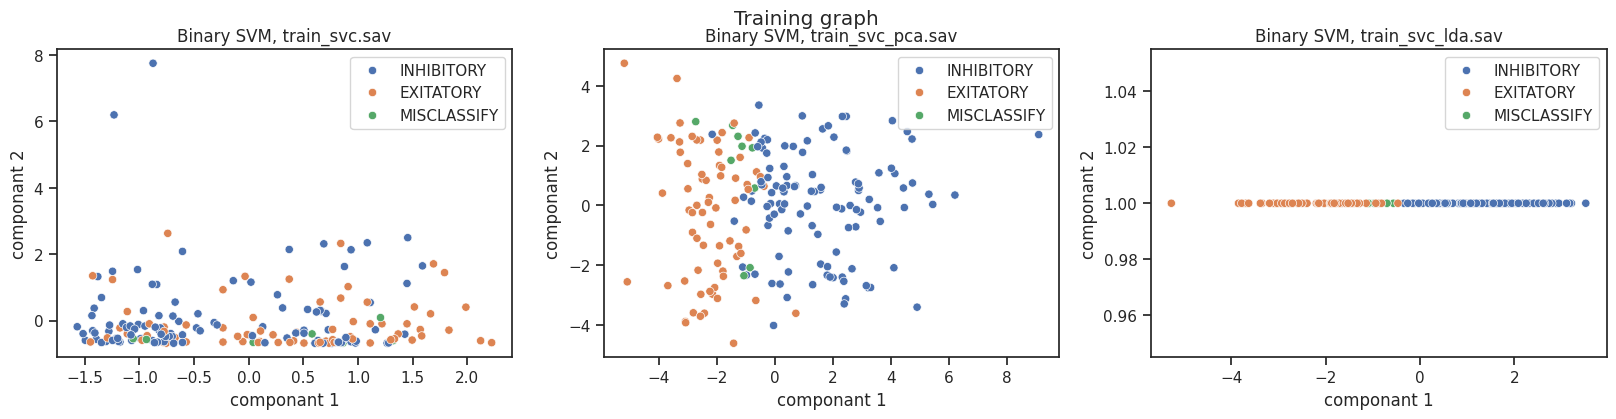

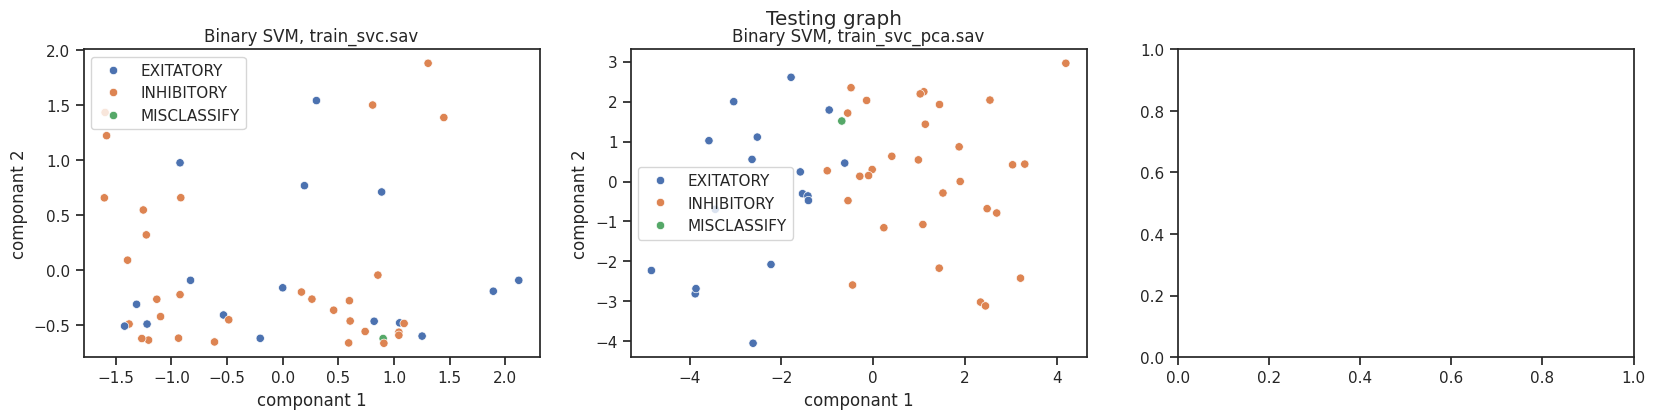

In [151]:
# STEP 1 : binary SVC
#path = f'{main_dir}models/'

# google colab
path = ''

for mode in ['Train', 'Test'] :
  fig, axs = plt.subplots(1, 3, figsize = (20, 4))
  fig.suptitle(f"{mode}ing graph")
  model_name = ['train_svc.sav', 'train_svc_pca.sav', 'train_svc_lda.sav']

  if mode == 'Train':
    X = [x_train_all, x_pca_bin, x_lda_bin]
    y_true = y_train_bin

  if mode == 'Test':
    X = [x_test_all , x_test_pca_bin, x_lda_bin]  # TODO : x_test_lda_bin
    y_true = y_test_bin


  for i in range(3) :
      # load the model
      model = pickle.load(open(os.path.join(path, model_name[i]), 'rb'))

      # Misclassify
      misclassified = [model.predict(X[i]) != y_true]
      float_misclassified = [m *1 for m in misclassified]

      y_labels = y_true + float_misclassified
      y_maps = {0: 'EXITATORY', 1: 'INHIBITORY', 2: 'MISCLASSIFY'}
      y_labels_ =[y_maps[i] for i in y_labels[0]]

      df_result = pd.DataFrame(X[i][:,:2])
      df_result['Labels'] = y_labels_


      sns.scatterplot(data=df_result,x=0, y=1, hue='Labels', ax=axs[i])
      axs[i].set_xlabel('componant 1')
      axs[i].set_ylabel('componant 2')
      axs[i].legend()

      axs[i].set_title(f"Binary SVM, {model_name[i]}")

In [ ]:
# STEP 1 : KNN
#path = f'{main_dir}models/'

#google collab
path = ''
for mode in ['Train', 'Test'] :
  fig, axs = plt.subplots(1, 3, figsize = (20, 4))
  fig.suptitle("Training graph")
  model_name = ['train_knn.sav', 'train_knn_pca.sav', 'train_knn_lda.sav']

  if mode == 'Train':
    X = [x_train_all, x_pca_bin, x_lda_bin]
    y_true = y_train_bin

  if mode == 'Test':
    X = [x_test_all , x_test_pca_bin, x_lda_bin]  # TODO : x_test_lda_bin
    y_true = y_test_bin


  for i in range(3) :
      # load the model
      model = pickle.load(open(os.path.join(path, model_name[i]), 'rb'))

      # Misclassify
      misclassified = [model.predict(X[i]) != y_true]
      float_misclassified = [m *1 for m in misclassified]

      y_labels = y_true + float_misclassified
      y_maps = {0: 'EXITATORY', 1: 'INHIBITORY', 2: 'MISCLASSIFY'}
      y_labels_ =[y_maps[i] for i in y_labels[0]]

      df_result = pd.DataFrame(X[i][:,:2])
      df_result['Labels'] = y_labels_


      sns.scatterplot(data=df_result,x=0, y=1, hue='Labels', ax=axs[i])
      axs[i].set_xlabel('componant 1')
      axs[i].set_ylabel('componant 2')
      axs[i].legend()

      axs[i].set_title(f"Binary KNN, {model_name[i]}")

In [ ]:
# STEP 2 : inhibitory KNN
#path = f'{main_dir}models/'

for mode in ['Train', 'Test'] :
  fig, axs = plt.subplots(1, 3, figsize = (20, 4))
  fig.suptitle("Training graph")

  model_name = ['train_knn_inhib.sav', 'train_knn_pca_inhib.sav', 'train_knn_lda_inhib.sav']
  model1 = ['train_svc.sav', 'train_svc_pca.sav', 'train_svc_lda.sav']

  if mode == 'Train':
    X1 = [x_train_all, x_pca_bin, x_lda_bin]
    X2 = [x_train_all, x_pca_inhib, x_lda_inhib]  # TODO x_train_all?
    y_true = y_train_bin

  if mode == 'Test':
    X1 = [x_test_all , x_test_pca_bin, x_lda_bin]  # TODO : x_test_lda_bin?
    X2 = [x_test_all, x_test_pca_inhib, x_test_lda_inhib]  # TODO?
    y_true = y_test_bin

  for i in range(3) :
      model1 = pickle.load(open(os.path.join(path, model1[i]), 'rb'))
      y_pred=model1.predict(X1[i])

      id_pred=np.where(y_pred==1)[0]

      model = pickle.load(open(os.path.join(path, model_name[i]), 'rb'))

      y_pred[id_pred]=model.predict(X2[i][id_pred])

      # Misclassify
      misclassified = [id_pred != y_train_inhib]
      float_misclassified = [m * 1 for m in misclassified]

      y_labels = y_train_bin + float_misclassified
      y_maps = {0: 'EX', 10: 'PV', 11: 'SST', 12: 'VIP',1:'misclassify'}
      y_labels_ =[y_maps[i] for i in y_labels[0]]

      df_result = pd.DataFrame(X2[i][:,:2])
      df_result['Labels'] = y_labels_

      sns.scatterplot(data=df_result,x=0, y=1, hue='Labels', ax=axs[i][j])
      axs[i].set_xlabel('componant 1')
      axs[i].set_ylabel('componant 2')
      axs[i].legend()

      axs[i].set_title(f"INHIBITORY KNN, {model_name[i]}, {model1[i]}")